# Análisis exploratorio de datos SIAP y SNIIM

In [110]:
# Importamos librerías a utilizar
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display
import datetime
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import geopandas
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# Para que no se desplieguen las advertencias
warnings.filterwarnings("ignore")

Cultivos con los que trabaja la Red BAMX.

In [3]:
# Cultivos de interés
CULTIVOS = ['Tomate rojo (jitomate)', 'Chile verde', 'Limón', 'Pepino', 'Plátano', 'Mango', 'Garbanzo', 'Brócoli', 'Cebolla', 'Sandía', 'Papaya', 'Calabacita', 'Lechuga',
            'Tomate verde', 'Espárrago', 'Frambuesa', 'Nopalitos', 'Nuez', 'Fresa', 'Toronja (pomelo)', 'Zarzamora', 'Piña', 'Coliflor', 'Frijol', 'Berenjena', 'Uva', 'Guayaba',
            'Naranja', 'Papa', 'Melón', 'Manzana', 'Pera', 'Durazno']

# Cantidad de cultivos
print(f"Cantidad de cultivos de interés: {len(CULTIVOS)}")

Cantidad de cultivos de interés: 33


## SIAP

In [4]:
# URL al archivo parquet en el repositorio
url_siap = r'C:\Users\jcbar\OneDrive\Documentos\Ingeniería de Características\Proyecto\Primera parte\Tidy\SIAP.parquet'
# Cargar archivo parquet como DataFrame
df_siap = pd.read_parquet(url_siap)
# Inspeccionar primeros elementos del DataFrame
df_siap.head()

,Entidad,Municipio,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion,Rendimiento,Anio,Mes,Cultivo
0,Aguascalientes,Aguascalientes,8.00,0.00,0.0,0.00,0,2023,Enero,Agave
1,Baja California Sur,La Paz,3.00,0.00,0.0,0.00,0,2023,Enero,Agave
2,Colima,Manzanillo,86.29,0.00,0.0,0.00,0,2023,Enero,Agave
3,Durango,Durango,13.00,0.00,0.0,0.00,0,2023,Enero,Agave
4,Durango,Mezquital,110.00,0.00,0.0,0.00,0,2023,Enero,Agave


In [5]:
# Cambiar nombre de columna "Anio" a "Año"
df_siap = df_siap.rename(columns={"Anio":"Año"})

#### Aplicar filtros

In [6]:
# Filtrar años del 2020 en adelante
df_siap = df_siap[df_siap['Año'] >= 2020]

In [7]:
# Filtrar cultivos de interés
df_siap = df_siap[df_siap['Cultivo'].isin(CULTIVOS)]

#### Dimensiones de los datos

In [8]:
# Dimensión de nuestros datos
print(f"Dimensión de los datos: {df_siap.shape}\n")

Dimensión de los datos: (387646, 10)



#### Tipos de datos

In [9]:
# Tipo de dato de cada variable
print(f"Tipo de dato de cada variable:\n {df_siap.dtypes}\n")

Tipo de dato de cada variable:
 Entidad                    object
Municipio                  object
Superficie Sembrada        object
Superficie Cosechada       object
Superficie Siniestrada    float64
Produccion                 object
Rendimiento                object
Año                         int64
Mes                        object
Cultivo                    object
dtype: object



Notamos que las variables *Superficie Sembrada*, *Superficie Cosechada*, *Producción* y *Rendimiento* son de tipo **object**, pese a que su valor es numérico

Convertimos estas variables object a flotantes

In [10]:
# Lista de variables a convertir
obj_to_float_var = ['Superficie Sembrada', 'Superficie Cosechada', 'Produccion', 'Rendimiento']

# Eliminación de ',' character y conversión a flotante
for var in obj_to_float_var:
    df_siap[var] = df_siap[var].str.replace(',','').astype('float')

# Tipo de dato de cada variable
print(f"Tipo de dato de cada variable:\n {df_siap.dtypes}\n")

Tipo de dato de cada variable:
 Entidad                    object
Municipio                  object
Superficie Sembrada       float64
Superficie Cosechada      float64
Superficie Siniestrada    float64
Produccion                float64
Rendimiento               float64
Año                         int64
Mes                        object
Cultivo                    object
dtype: object



### Valores faltantes

In [11]:
# Valores faltantes
print(f"Valores faltantes:\n {df_siap.isna().sum()}")

Valores faltantes:
 Entidad                   0
Municipio                 0
Superficie Sembrada       0
Superficie Cosechada      0
Superficie Siniestrada    0
Produccion                0
Rendimiento               0
Año                       0
Mes                       0
Cultivo                   0
dtype: int64


#### Definición de constantes

In [12]:
# Orden cronológico de los meses
MESES_CRONOLOGICO = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

# Lista de colores para cada año
COLORES = ['#ffd343', '#42ff75', '#426eff', '#ff42cc']

# Lista de cultivos únicos
CULTIVOS_UNICOS = list(df_siap['Cultivo'].unique())

# Lista de años únicos
AÑOS_UNICOS = list(df_siap['Año'].unique())

# Lista de estado únicos
ESTADOS_UNICOS = list(df_siap['Entidad'].unique())

# Lista de estado únicos
MUNICIPIOS_UNICOS = list(df_siap['Municipio'].unique())

#### Obtención de valores mensuales

Por defecto, el SIAP arroja los datos numéricos (Superficie Sembrada, Superficie Cosechada, Superficie Siniestrada, Produccion, Rendimiento) de manera acumulativa. Esto implica que, para un año dado, los valores de, por ejemplo Febrero, son los valores de Enero más los de Febrero; los valores de Marzo son los valores de Enero, más los de Febrero, más los de Marzo; y así sucesivamente. Nosotros estamos interesados en analizar los valores de manera mensual y por ende, es necesario que a los valores de cada mes le restemos los valores de los meses previos. Aún así, decidimos mantener los datos acumulativos originales como referencia para corroborar que los valores mensuales se obtuvieron correctamente, y en caso de que sean de utilidad más adelante en el EDA.

In [13]:
# Hacemos que la columna Mes sea una categoría con un orden cronológico
df_siap['Mes'] = pd.Categorical(df_siap['Mes'], categories=MESES_CRONOLOGICO, ordered=True)

# Ordenar por 'Año' y 'Mes'
df_siap = df_siap.sort_values(by=['Año', 'Mes'])

# Operación de diferencia por grupo
cols_to_diff = ["Superficie Sembrada", "Superficie Cosechada", "Superficie Siniestrada", "Produccion"]

df_siap_diff = df_siap.groupby(['Entidad', 'Municipio', 'Cultivo'])[cols_to_diff].diff().fillna(df_siap[cols_to_diff])

# Reemplazar NaN en Enero con los valores acumulados originales
mask_enero = df_siap['Mes'] == 'Enero'
df_siap_diff.loc[mask_enero, :] = df_siap.loc[mask_enero, cols_to_diff].values

# Agregar las columnas de diferencia al DataFrame original
df_siap = pd.concat([df_siap, df_siap_diff], axis=1)

# Verificar los resultados
df_siap.head()

,Entidad,Municipio,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion,Rendimiento,Año,Mes,Cultivo,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion
565841,Baja California Sur,La Paz,8.0,0.0,0.0,0.0,0.0,2020,Enero,Berenjena,8.0,0.0,0.0,0.0
565842,Baja California Sur,Los Cabos,3.0,0.0,0.0,0.0,0.0,2020,Enero,Berenjena,3.0,0.0,0.0,0.0
565843,Morelos,Miacatlán,0.4,0.0,0.0,0.0,0.0,2020,Enero,Berenjena,0.4,0.0,0.0,0.0
565844,Nayarit,Santiago Ixcuintla,60.0,0.0,0.0,0.0,0.0,2020,Enero,Berenjena,60.0,0.0,0.0,0.0
565845,Quintana Roo,Bacalar,12.5,10.0,0.0,49.0,4.9,2020,Enero,Berenjena,12.5,10.0,0.0,49.0


In [14]:
# Cambiar el nombre de las columnas originales
df_siap.columns.values[2] = "Superficie Sembrada Acumulada"
df_siap.columns.values[3] = "Superficie Cosechada Acumulada"
df_siap.columns.values[4] = "Superficie Siniestrada Acumulada"
df_siap.columns.values[5] = "Produccion Acumulada"

# Verificar los resultados
df_siap.head()

,Entidad,Municipio,Superficie Sembrada Acumulada,Superficie Cosechada Acumulada,Superficie Siniestrada Acumulada,Produccion Acumulada,Rendimiento,Año,Mes,Cultivo,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion
565841,Baja California Sur,La Paz,8.0,0.0,0.0,0.0,0.0,2020,Enero,Berenjena,8.0,0.0,0.0,0.0
565842,Baja California Sur,Los Cabos,3.0,0.0,0.0,0.0,0.0,2020,Enero,Berenjena,3.0,0.0,0.0,0.0
565843,Morelos,Miacatlán,0.4,0.0,0.0,0.0,0.0,2020,Enero,Berenjena,0.4,0.0,0.0,0.0
565844,Nayarit,Santiago Ixcuintla,60.0,0.0,0.0,0.0,0.0,2020,Enero,Berenjena,60.0,0.0,0.0,0.0
565845,Quintana Roo,Bacalar,12.5,10.0,0.0,49.0,4.9,2020,Enero,Berenjena,12.5,10.0,0.0,49.0


Comprobamos que no hayan valores faltantes

In [15]:
# Valores faltantes
print(f"Valores faltantes:\n {df_siap.isna().sum()}")

Valores faltantes:
 Entidad                             0
Municipio                           0
Superficie Sembrada Acumulada       0
Superficie Cosechada Acumulada      0
Superficie Siniestrada Acumulada    0
Produccion Acumulada                0
Rendimiento                         0
Año                                 0
Mes                                 0
Cultivo                             0
Superficie Sembrada                 0
Superficie Cosechada                0
Superficie Siniestrada              0
Produccion                          0
dtype: int64


#### Definimos constantes

In [16]:
# Lista de variables numéricas en el DataFrame
VARIABLES_NUMERICAS_SIAP = ["Superficie Sembrada", "Superficie Cosechada", "Superficie Siniestrada", "Produccion", "Rendimiento",
                             "Superficie Sembrada Acumulada", "Superficie Cosechada Acumulada", "Superficie Siniestrada Acumulada", "Produccion Acumulada"]

In [17]:
# # Ordenamos el DataFrame con base en el orden cronológico de los meses
# df_siap['Mes'] = pd.Categorical(df_siap['Mes'], categories=MESES_CRONOLOGICO, ordered=True)  # Convertir 'Mes' en una categoría con el orden cronológico
# df_siap = df_siap.sort_values(by='Mes')  # Ordenar DataFrame con base en la columna 'Mes'

# # Crear DataFrame en el que almacenaremos la producción mensual no acumulativa
# df_siap_diff = pd.DataFrame(columns=df_siap.columns)

# # Iteramos por año
# for año in AÑOS_UNICOS[::-1]:

#    # Iteramos por estado
#    for estado in ESTADOS_UNICOS:
       
#        # Iteramos por cultivo
#        for cultivo in CULTIVOS_UNICOS:

#            # Datos del estado, año y cultivo en turno
#            df_ent_year_cult = df_siap_diff[(df_siap['Entidad'] == estado) & (df_siap['Año'] == año) & (df_siap['Cultivo'] == cultivo)]

#            # Resta de valores de meses previos
#            df_ent_year_cult['Superficie Sembrada'] = df_ent_year_cult['Superficie Sembrada Acumulada'].diff().fillna(df_ent_year_cult['Superficie Sembrada Acumulada'])
#            df_ent_year_cult['Superficie Cosechada'] = df_ent_year_cult['Superficie Cosechada Acumulada'].diff().fillna(df_ent_year_cult['Superficie Cosechada Acumulada'])
#            df_ent_year_cult['Superficie Siniestrada'] = df_ent_year_cult['Superficie Siniestrada Acumulada'].diff().fillna(df_ent_year_cult['Superficie Siniestrada Acumulada'])
#            df_ent_year_cult['Produccion'] = df_ent_year_cult['Produccion Acumulada'].diff().fillna(df_ent_year_cult['Produccion Acumulada'])
#            #df_ent_year_cult['Rendimiento'] = df_ent_year_cult['Rendimiento'].diff().fillna(df_ent_year_cult['Rendimiento'])

#            # Alamacenar resultados en el nuevo DataFrame
#            df_siap_diff = pd.concat([df_siap_diff, df_ent_year_cult], axis=0)

#            df_siap_diff = df_siap_diff.reset_index(drop=True)

# # Inspeccionamos el nuevo DataFrame
# df_siap_diff

### Pandas Profiling

In [18]:
# Código para visualizar mejor los reportes en jupyter
# !jupyter nbextension enable --py widgetsnbextension

In [19]:
#pip install ydata-profiling

In [20]:
# # Código para obtener un super resumen automático de los datos
# from ydata_profiling import ProfileReport

# siap_profile = ProfileReport(df_siap, title="Pandas Profiling Report - SIAP")
# siap_profile.to_notebook_iframe()

In [21]:
#Exportamos el reporte a un archivo html que es guardado en la misma carpeta. 
#siap_profile.to_file('siap-profiling-report')

### Detección de outliers

In [22]:
# Descripción de variables numéricas
df_siap.drop(columns='Año', axis=1).describe().round(2)

,Superficie Sembrada Acumulada,Superficie Cosechada Acumulada,Superficie Siniestrada Acumulada,Produccion Acumulada,Rendimiento,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion
count,387646.00,387646.00,387646.00,387646.00,387646.00,387646.00,387646.00,387646.00,387646.00
mean,293.41,163.20,2.55,2100.48,12.66,22.71,18.42,0.55,291.64
std,1785.48,1137.74,175.58,12469.44,27.83,714.08,762.76,94.87,3039.27
min,0.00,0.00,0.00,0.00,0.00,-84685.00,-119950.00,-11653.00,-243853.50
25%,7.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,24.00,5.50,0.00,37.00,3.20,0.00,0.00,0.00,0.00
75%,98.00,40.00,0.00,418.00,15.53,0.00,0.00,0.00,16.37
max,120900.00,119950.00,28372.00,722238.00,696.43,93500.00,84040.00,28372.00,300352.00


Notamos que los valores mínimos de las nuevas columnas con datos mensuales son negativos, lo cual no tiene sentido. Contamos la cantidad de valores negativos en estas variables, con el objetivo de identificar si cometimos un error en el cálculo de los valores mensuales, o si simplemente se trata de que hubo errores a la hora de registrar los datos. 

In [23]:
# Evaluar cantidad y porcentaje respectivo de valores negativos por columnas 
print(f"Cantidad de valores negativos en Superficie Sembrada: {sum(df_siap['Superficie Sembrada'] < 0)} ({round(sum(df_siap['Superficie Sembrada'] < 0)/len(df_siap) * 100,2)}%)\n")
print(f"Cantidad de valores negativos en Superficie Cosechada: {sum(df_siap['Superficie Cosechada'] < 0)} ({round(sum(df_siap['Superficie Cosechada'] < 0)/len(df_siap) * 100,2)}%)\n")
print(f"Cantidad de valores negativos en Superficie Siniestrada: {sum(df_siap['Superficie Siniestrada'] < 0)} ({round(sum(df_siap['Superficie Siniestrada'] < 0)/len(df_siap) * 100,2)}%)\n")
print(f"Cantidad de valores negativos en Produccion: {sum(df_siap['Produccion'] < 0)} ({round(sum(df_siap['Produccion'] < 0)/len(df_siap) * 100,2)}%)")

Cantidad de valores negativos en Superficie Sembrada: 6907 (1.78%)

Cantidad de valores negativos en Superficie Cosechada: 9522 (2.46%)

Cantidad de valores negativos en Superficie Siniestrada: 438 (0.11%)

Cantidad de valores negativos en Produccion: 9606 (2.48%)


Debido a la pequeña cantidad de valores faltantes, lo más factible es que se hayan cometido errores a la hora de registrar los datos. Por lo tanto, podemos simplemente eliminar estos valores negativos y continuar con el análisis.

In [24]:
# Descartar filas con valores valores negativos
df_siap  = df_siap[(df_siap['Superficie Sembrada'] >= 0) & (df_siap['Superficie Cosechada'] >= 0) & (df_siap['Superficie Siniestrada'] >= 0) & (df_siap['Produccion'] >= 0) ]

# Repetir describe
df_siap.drop(columns='Año', axis=1).describe().round(2)

,Superficie Sembrada Acumulada,Superficie Cosechada Acumulada,Superficie Siniestrada Acumulada,Produccion Acumulada,Rendimiento,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion
count,377937.00,377937.00,377937.00,377937.00,377937.00,377937.00,377937.00,377937.00,377937.00
mean,297.54,167.24,2.62,2151.31,12.97,31.80,29.81,0.93,348.98
std,1791.53,1151.34,177.81,12618.12,28.09,558.01,515.38,89.39,2736.83
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,7.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,24.50,6.00,0.00,42.25,3.80,0.00,0.00,0.00,0.00
75%,100.00,41.00,0.00,445.00,15.95,0.00,0.00,0.00,18.73
max,120900.00,119950.00,28372.00,722238.00,696.43,93500.00,84040.00,28372.00,300352.00


#### Dispersión de los datos

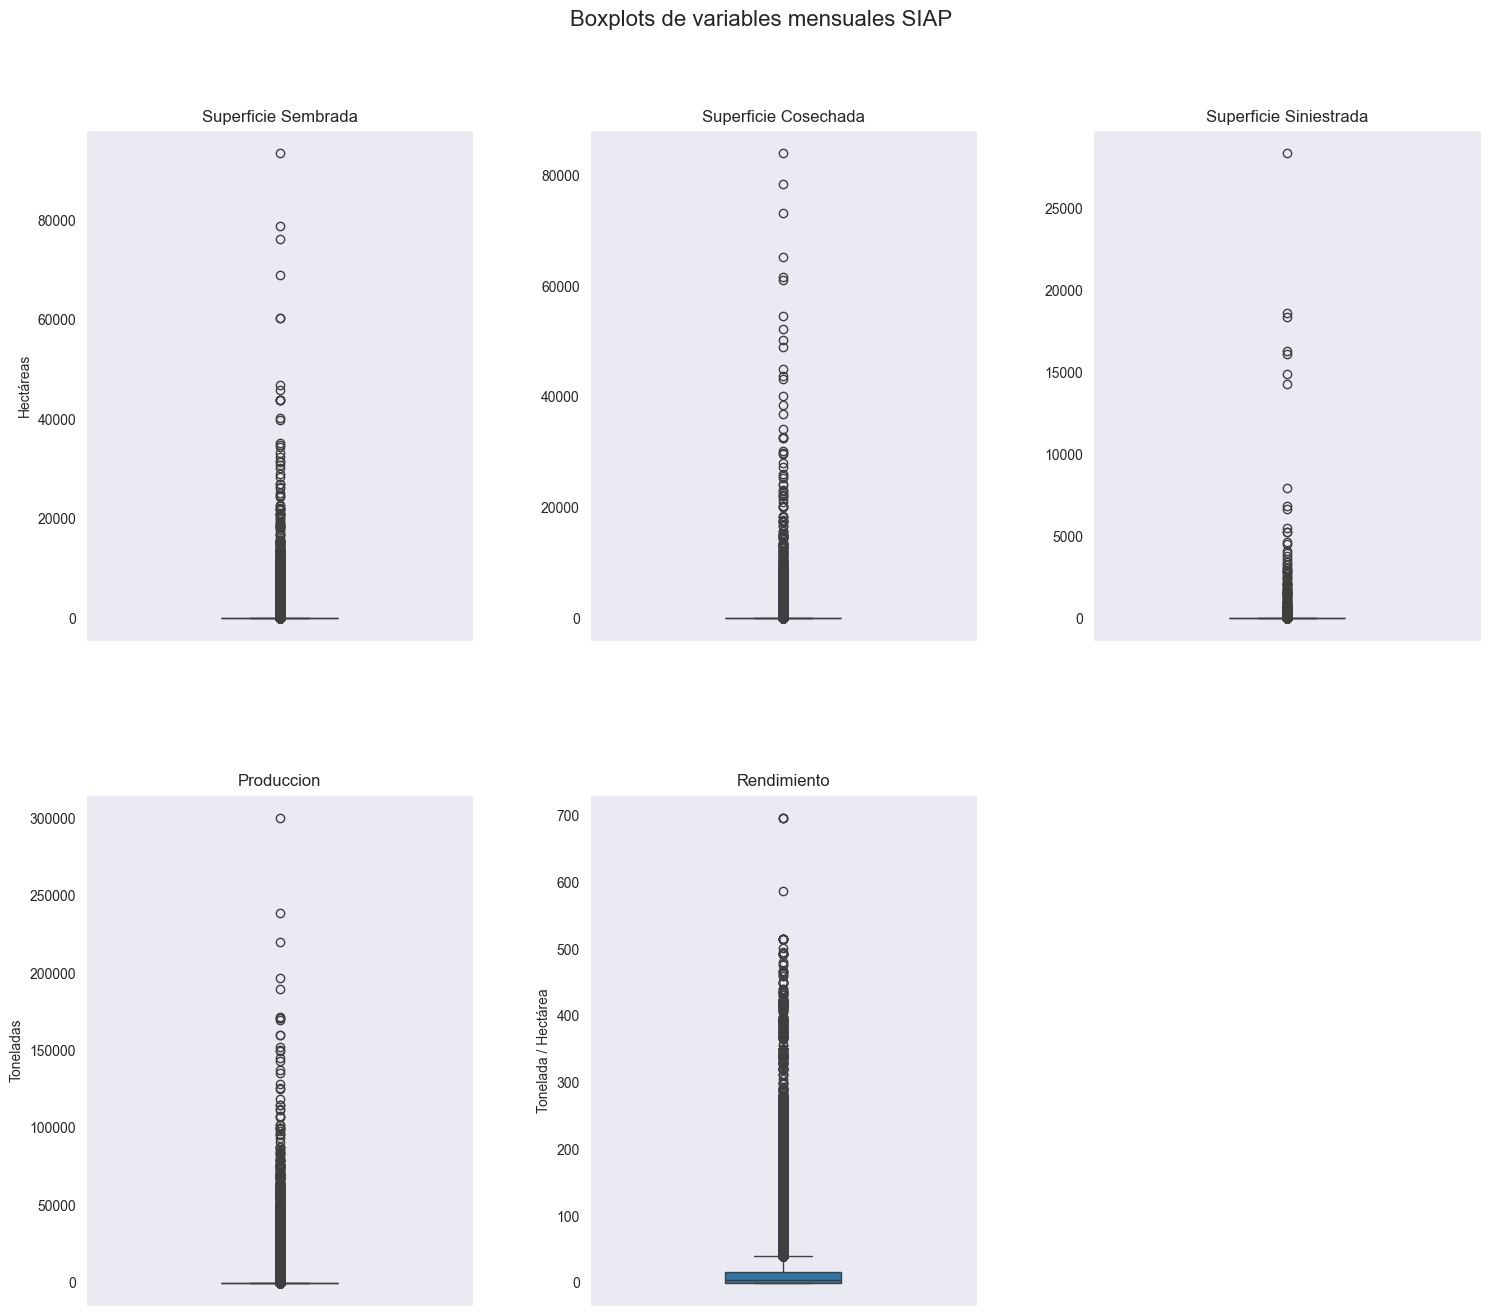

In [25]:
# Fijamos estilo
sns.set_style("dark")

# Configurar la figura y los subplots
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 12))
# Ajustar el espacio entre subplots
fig.subplots_adjust(wspace=0.3, hspace=0.3, bottom=-0.1)

# Asegurarse de que 'axes' sea una matriz 2D
axes = axes.reshape(-1)

# Iterar a través de las columnas numéricas y crear boxplots divididos por HeartDisease
for i, variable in enumerate(VARIABLES_NUMERICAS_SIAP[:5]):
    sns.boxplot(data=df_siap, y=variable, ax=axes[i], width=0.3)
    axes[i].set_title(f'{variable}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Eliminar la subgráfica vacía 
fig.delaxes(axes[-1])

# Agregar un título general a la figura
fig.suptitle('Boxplots de variables mensuales SIAP', fontsize=16)

axes[0].set_ylabel('Hectáreas')
axes[3].set_ylabel('Toneladas')
axes[4].set_ylabel('Tonelada / Hectárea')

# Ajustar el espaciado entre subplots
#plt.tight_layout()

# Mostrar la figura
plt.show()

In [26]:
# # Configurar la figura y los subplots
# num_rows = 2
# num_cols = 3
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 12))
# # Ajustar el espacio entre subplots
# fig.subplots_adjust(wspace=0.3, hspace=0.3, bottom=-0.1)

# # Asegurarse de que 'axes' sea una matriz 2D
# axes = axes.reshape(-1)

# # Iterar a través de las columnas numéricas y crear histogramas de densidad kde
# for i, variable in enumerate(VARIABLES_NUMERICAS_MENSUALES):
#     sns.histplot(data=df_siap, x=variable, kde=True, ax=axes[i])
#     axes[i].set_title(f'{variable}')
#     axes[i].set_xlabel('')
#     axes[i].set_ylabel('')

# # Eliminar la subgráfica vacía correspondiente a la variable FastingBS
# fig.delaxes(axes[-1])

# # Agregar un título general a la figura
# fig.suptitle('Distribuciones de densidad de variables mensuales SIAP', fontsize=16)

# axes[0].set_ylabel('Hectáreas')
# axes[3].set_ylabel('Toneladas')
# axes[4].set_ylabel('Tonelada / Hectárea')

# # Ajustar el espaciado entre subplots
# #plt.tight_layout()

# # Mostrar la figura
# plt.show()

#### Método Local Factor Outlier

In [27]:
# Crear modelo 
clf = LocalOutlierFactor(n_neighbors=20)

# Quitar columnas cualitativas 
X = df_siap.drop(columns=['Entidad', 'Municipio', 'Año', 'Mes', 'Cultivo'])

# Buscar outliers
estimado_LOF = clf.fit_predict(X)

# Contar y mostrar resultados
cantidad_outliers_LOF = abs(estimado_LOF[estimado_LOF==-1].sum())
porcentaje_outliers_LOF = cantidad_outliers_LOF / len(df_siap) * 100

print(f"Cantidad de outliers: {cantidad_outliers_LOF}")
print(f"Porcentaje con respecto al total de datos: {porcentaje_outliers_LOF:.2f}%")

Cantidad de outliers: 29552
Porcentaje con respecto al total de datos: 7.82%


Inspeccionamos algunos datos outlier según Local Factor Outlier

In [28]:
# Obtener datos outlier según LOF
outliers_LOF = df_siap[(estimado_LOF==-1)]

# Inspeccionar muestras de outliers
outliers_LOF.sample(n=10)

,Entidad,Municipio,Superficie Sembrada Acumulada,Superficie Cosechada Acumulada,Superficie Siniestrada Acumulada,Produccion Acumulada,Rendimiento,Año,Mes,Cultivo,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion
605135,Oaxaca,San Andrés Paxtlán,9.89,0.00,0.0,0.00,0.00,2020,Abril,Durazno,0.00,0.0,0.0,0.00
263776,Oaxaca,Santa María Yavesía,7.25,7.25,0.0,17.67,2.44,2022,Agosto,Durazno,0.00,0.0,0.0,1.28
557964,Chihuahua,Delicias,4219.00,2835.00,0.0,4171.80,1.47,2021,Diciembre,Nuez,0.00,97.0,0.0,0.00
79409,Veracruz,Santiago Sochiapan,180.00,180.00,0.0,162.00,0.90,2023,Junio,Frijol,0.00,8.0,0.0,8.92
22388,Veracruz,Omealca,20.60,0.00,0.0,0.00,0.00,2023,Febrero,Naranja,0.00,0.0,0.0,0.00
362049,Guerrero,Florencio Villarreal,32.42,0.00,0.0,0.00,0.00,2021,Enero,Frijol,32.42,0.0,0.0,0.00
44893,Oaxaca,San Juan Teposcolula,2.01,0.00,0.0,0.00,0.00,2023,Abril,Durazno,0.00,0.0,0.0,0.00
645056,Guerrero,Ahuacuotzingo,12.68,9.18,0.0,181.12,19.73,2020,Junio,Tomate rojo (jitomate),3.50,0.0,0.0,0.00
488217,Hidalgo,Huasca de Ocampo,1.27,0.00,0.0,0.00,0.00,2021,Septiembre,Calabacita,0.00,0.0,0.0,0.00
263697,Oaxaca,Tamazulápam del Espíritu Santo,3.00,3.00,0.0,9.60,3.20,2022,Agosto,Durazno,0.00,0.0,0.0,0.60


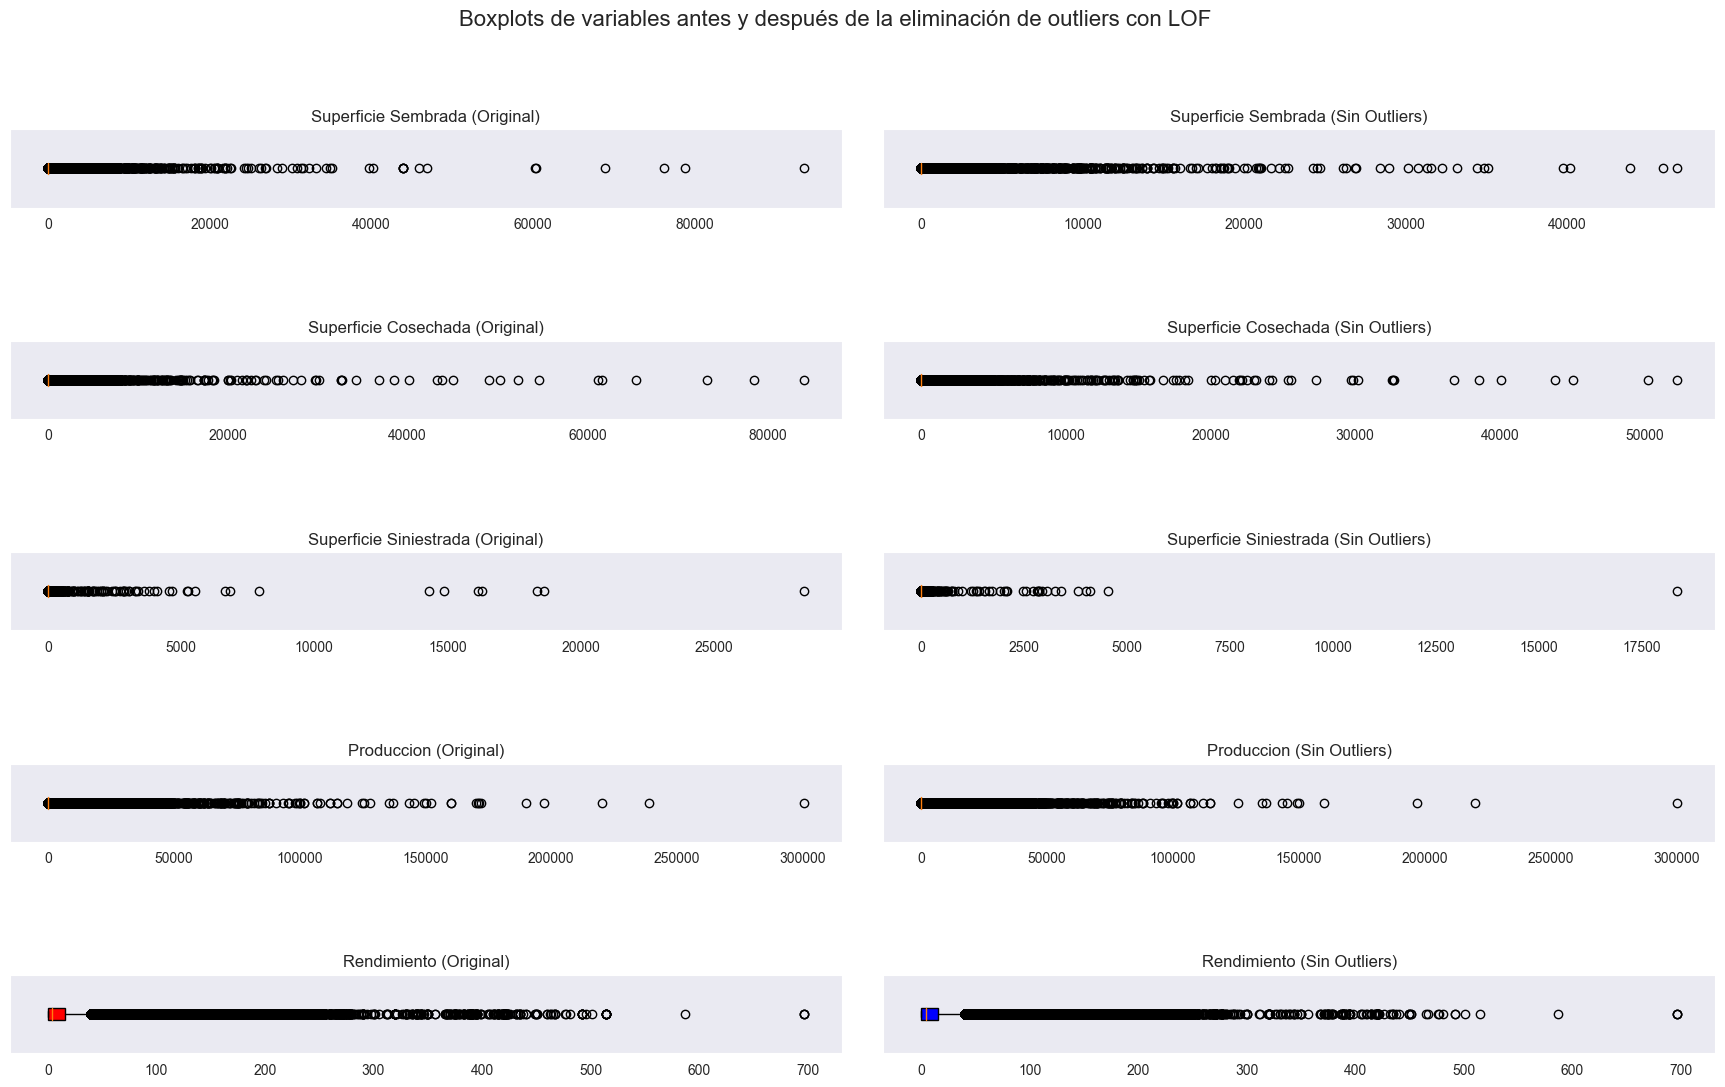

In [29]:
# Eliminar outliers del DataFrame
df_clean_LOF = df_siap[~(estimado_LOF==-1)]

# Configurar la figura y los subplots con orientación horizontal
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(22, 12))

# Iterar a través de las columnas numéricas y crear boxplots horizontales
for i, variable in enumerate(VARIABLES_NUMERICAS_SIAP[:5]):
    # Boxplot original en rojo con relleno rojo
    axes[i, 0].boxplot(df_siap[variable], vert=False, patch_artist=True, boxprops=dict(facecolor='red'))
    axes[i, 0].set_title(f'{variable} (Original)')

    # Boxplot sin outliers en azul con relleno azul
    axes[i, 1].boxplot(df_clean_LOF[variable], vert=False, patch_artist=True, boxprops=dict(facecolor='blue'))
    axes[i, 1].set_title(f'{variable} (Sin Outliers)')

    # Eliminar las etiquetas en la columna de la derecha
    axes[i, 0].set_yticklabels([])
    axes[i, 1].set_yticklabels([])

# Ajustar el espaciado entre subplots
#plt.tight_layout()

# Agregar un título general a la figura
fig.suptitle('Boxplots de variables antes y después de la eliminación de outliers con LOF', fontsize=16)

# Ajustar el espaciado entre subplots verticalmente
plt.subplots_adjust(hspace=1.7, wspace=0.05)

# Mostrar la figura
plt.show()

#### Método Isolation Forest

In [30]:
# Crear modelo Isolation Forest
random_state = np.random.RandomState(42)
clf = IsolationForest(n_estimators=100,max_samples='auto',random_state=random_state)  # Puedes ajustar el parámetro de contaminación según tus necesidades

# Quitar columnas cualitativas 
X = df_siap.drop(columns=['Entidad', 'Municipio', 'Año', 'Mes', 'Cultivo'])

# Entrenar el modelo y predecir outliers
estimado_IF = clf.fit_predict(X)

# Contar y mostrar resultados
cantidad_outliers_IF = len(estimado_IF[estimado_IF == -1])
porcentaje_outliers_IF = cantidad_outliers_IF / len(df_siap) * 100

print(f"Cantidad de outliers: {cantidad_outliers_IF}")
print(f"Porcentaje con respecto al total de datos: {porcentaje_outliers_IF:.2f}%")


Cantidad de outliers: 20338
Porcentaje con respecto al total de datos: 5.38%


Inspeccionamos algunos datos outlier según Isolation Forest

In [31]:
# Obtener datos outlier según IF
outliers_IF = df_siap[(estimado_IF==-1)]

# Inspeccionar muestras de outliers
outliers_IF.sample(n=10)

,Entidad,Municipio,Superficie Sembrada Acumulada,Superficie Cosechada Acumulada,Superficie Siniestrada Acumulada,Produccion Acumulada,Rendimiento,Año,Mes,Cultivo,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion
513602,Michoacán,Aguililla,1916.00,1916.0,0.0,44041.16,22.99,2021,Octubre,Limón,0.0,0.00,0.0,4036.64
324203,Guanajuato,Apaseo El Alto,1003.00,1003.0,0.0,1055.20,1.05,2022,Noviembre,Frijol,0.0,680.00,0.0,579.15
170926,Veracruz,Coatzintla,1309.00,780.0,0.0,12480.00,16.00,2022,Febrero,Naranja,0.0,480.00,0.0,7680.00
251762,Veracruz,Cazones de Herrera,3282.00,3278.0,0.0,52448.00,16.00,2022,Julio,Naranja,0.0,0.00,0.0,0.00
167369,Sinaloa,Navolato,4591.64,2102.0,0.0,3488.81,1.66,2022,Febrero,Frijol,0.0,2098.00,0.0,3485.61
392021,Veracruz,Chicontepec,9917.00,5137.0,0.0,76588.89,14.91,2021,Marzo,Naranja,0.0,3898.00,0.0,58107.01
653439,Sonora,Caborca,8331.00,8225.0,0.0,88067.50,10.71,2020,Julio,Espárrago,0.0,0.00,0.0,1922.50
128614,Michoacán,Peribán,1534.00,1522.0,0.0,36191.46,23.78,2023,Agosto,Zarzamora,0.0,0.00,0.0,33.01
553205,Oaxaca,Villa de Tututepec de Melchor Ocampo,3596.00,3592.0,0.0,55710.21,15.51,2021,Diciembre,Limón,0.0,0.00,0.0,3184.50
596806,Veracruz,Castillo de Teayo,10775.00,10761.0,0.0,64386.36,5.98,2020,Marzo,Naranja,0.0,8121.13,0.0,45748.88


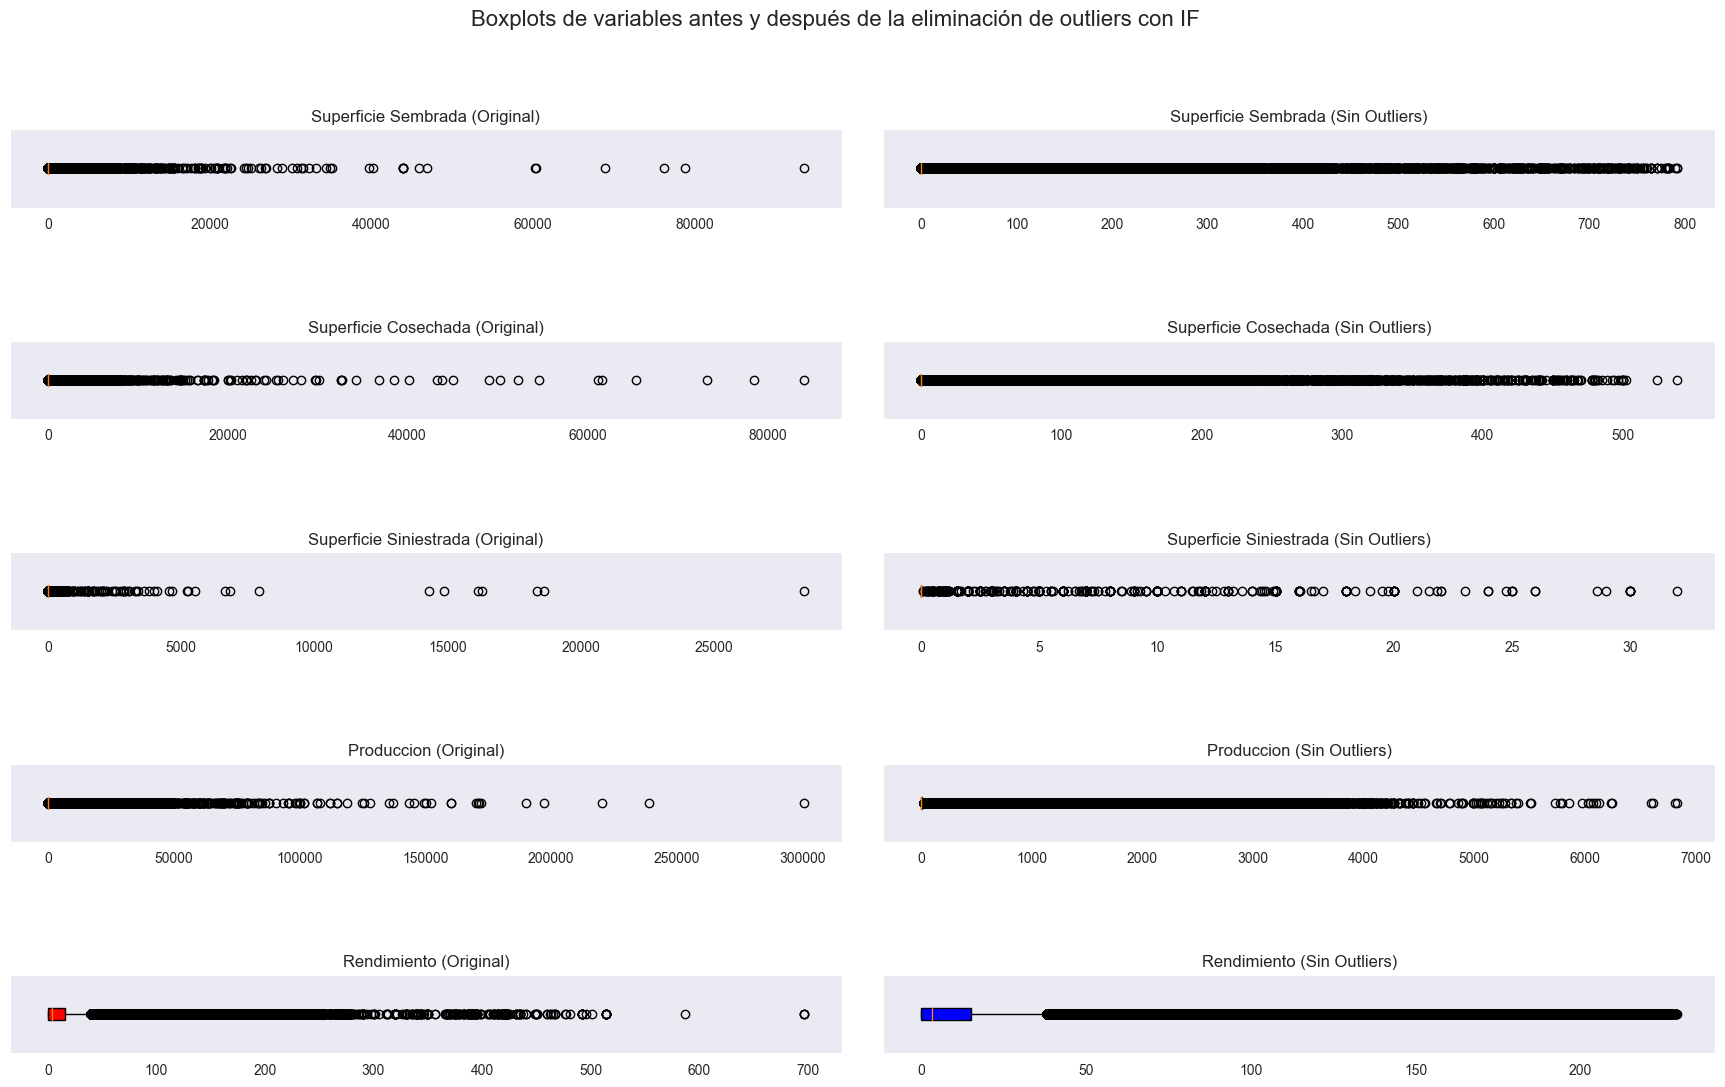

In [32]:
# Eliminar outliers del DataFrame
df_clean_IF = df_siap[~(estimado_IF==-1)]

# Configurar la figura y los subplots con orientación horizontal
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(22, 12))

# Iterar a través de las columnas numéricas y crear boxplots horizontales
for i, variable in enumerate(VARIABLES_NUMERICAS_SIAP[:5]):
    # Boxplot original en rojo con relleno rojo
    axes[i, 0].boxplot(df_siap[variable], vert=False, patch_artist=True, boxprops=dict(facecolor='red'))
    axes[i, 0].set_title(f'{variable} (Original)')

    # Boxplot sin outliers en azul con relleno azul
    axes[i, 1].boxplot(df_clean_IF[variable], vert=False, patch_artist=True, boxprops=dict(facecolor='blue'))
    axes[i, 1].set_title(f'{variable} (Sin Outliers)')

    # Eliminar las etiquetas en la columna de la derecha
    axes[i, 0].set_yticklabels([])
    axes[i, 1].set_yticklabels([])

# Ajustar el espaciado entre subplots
#plt.tight_layout()

# Agregar un título general a la figura
fig.suptitle('Boxplots de variables antes y después de la eliminación de outliers con IF', fontsize=16)

# Ajustar el espaciado entre subplots verticalmente
plt.subplots_adjust(hspace=1.7, wspace=0.05)

# Mostrar la figura
plt.show()

En ambos casos, la inspección de los outliers putativos no nos permite identificarlos como verdaderamente valores atípicos. Es esperable que en ciertas épocas la producción de algunos cultivos incremente de manera significativa. Por esto y otros factores, decidimos conservar los outliers putativos y continuar el EDA con el DataFrame completo.  

## SNIIM

In [37]:
# Path al archivo parquet
url_sniim = r'C:\Users\jcbar\OneDrive\Documentos\Ingeniería de Características\Proyecto\Primera parte\Tidy\SNIIM.parquet'
# Cargar archivo parquet como DataFrame
df_sniim = pd.read_parquet(url_sniim)
# Inspeccionar primeros elementos del DataFrame
df_sniim.sample(n=5)

,Fecha,Presentacion,Origen,Destino,Precio Minimo,Precio Maximo,Precio Frecuente,Observacion,Cultivo
55595,15/04/2020,Kilogramo,Distrito Federal,"Campeche: Mercado ""Pedro Sáinz de Baranda"", Ca...",20.00,25.00,25.00,nan,brócoli_primera
717519,25/08/2021,Kilogramo,Chiapas,"Coahuila: Central de Abasto de La Laguna, Torreón",15.00,16.00,15.50,nan,piña mediana_primera
62644,10/12/2021,Costal de 11 kg.,Morelos,"Baja California : Central de Abasto INDIA, Tij...",40.91,40.91,40.91,nan,cacahuate_primera
408922,17/03/2020,Kilogramo,México,México: Central de Abasto de Toluca,12.00,15.00,14.00,nan,haba verde_primera
81101,06/12/2022,Caja de 20 kg.,Yucatán,Yucatán: Centro Mayorista Oxkutzcab,10.00,10.00,10.00,nan,calabacita regional_primera


Los valores de precio están estandarizados a KG y por ende las columnas "Presentacion" y "Observacion" son remanentes que podemos eliminar

In [38]:
# Descartamos columnas Presentacion y Observacion
df_sniim = df_sniim.drop(['Presentacion', 'Observacion'], axis=1)

#### Dimensiones de los datos

In [39]:
# Dimensión de nuestros datos
print(f"Dimensión de los datos: {df_sniim.shape}")

Dimensión de los datos: (900763, 7)


#### Tipos de datos

In [40]:
# Tipo de dato de cada variable
print(f"Tipo de dato de cada variable:\n {df_sniim.dtypes}\n")

Tipo de dato de cada variable:
 Fecha                object
Origen               object
Destino              object
Precio Minimo       float64
Precio Maximo       float64
Precio Frecuente    float64
Cultivo              object
dtype: object



Notamos que la variable *Fecha* es de tipo **object**, por lo que la convertimos a **datetime** para facilitar futuros análisis

In [41]:
# Efectuar conversión especificando el formato específico de la fecha
df_sniim['Fecha'] = pd.to_datetime(df_sniim['Fecha'], format="%d/%m/%Y")
# Inspeccionar nuevamente el tipo de dato de cada variable
print(f"Tipo de dato de cada variable:\n {df_sniim.dtypes}\n")

Tipo de dato de cada variable:
 Fecha               datetime64[ns]
Origen                      object
Destino                     object
Precio Minimo              float64
Precio Maximo              float64
Precio Frecuente           float64
Cultivo                     object
dtype: object



#### Aplicar filtros

In [42]:
#Filtramos nuestro DataFrame solo para los años 2020 - 2023 
df_sniim = df_sniim[df_sniim['Fecha'].dt.year >= 2020]

Nota: a causa de la diferencia en el nombre de los cultivos entre los DataFrames, el filtrado con los cultivos de interés de la Red BAMX se dejará para más adelante

#### Valores faltantes

In [43]:
# Valores faltantes
print(f"Valores faltantes:\n {df_sniim.isna().sum()}")

Valores faltantes:
 Fecha               0
Origen              0
Destino             0
Precio Minimo       0
Precio Maximo       0
Precio Frecuente    0
Cultivo             0
dtype: int64


### Homologar DataFrames

Antes de poder efectuar análisis conjuntos con estos DataFrames es necesario realizar ciertos pasos para homologar los datos:

- Ajustar los nombres de los estados de Origen en los datos del SNIIM
- Ajustar los nombres de los cultivos del SNIIM
- Promediar los precios del SNIIM de manera mensual

In [44]:
# # Eliminar columna 'Destino'
# df_sniim_dest = df_sniim.drop('Destino', axis=1)

# # Eliminar columna 'Municipio'
# df_siap_mun = df_siap.drop('Municipio', axis=1)

# # En ambos casos es necesario sumar los valores numericos que coincidad en Estado, Año, Mes y Cultivo 
# df_sniim_dest = df_sniim_dest.groupby(['Fecha', 'Origen', 'Cultivo'])[['Precio Minimo', 'Precio Maximo', 'Precio Frecuente']].sum().reset_index()
# df_siap_mun = df_siap_mun.groupby(['Año', 'Mes', 'Entidad', 'Cultivo'])[['Superficie Sembrada', 'Superficie Cosechada', 'Superficie Siniestrada', 'Produccion', 'Rendimiento']].sum().reset_index()

#### Ajustar los nombres de los estados de Origen

In [45]:
# Evaluamos qué nombres de estado en el sniim no están en el siap
print('Estados del SNIIM no presentes en el SIAP:\n')
for estado_sniim in df_sniim['Origen'].unique():
    if estado_sniim not in df_siap['Entidad'].unique():
        print(estado_sniim)

Estados del SNIIM no presentes en el SIAP:

Distrito Federal
Importación
Nacional


Reemplazamos "Distrito Federal" por "Ciudad de México" tal como viene en el SIAP. Descartamos las filas con datos "Importación", "Nacional" y "Sin Especificar"

In [46]:
# Crear copia del dataframe
df_sniim_orig = df_sniim.copy()

# Reemplazamos Distrito Federal por Ciudad de México
condicion = df_sniim_orig['Origen'] == "Distrito Federal"
df_sniim_orig.loc[condicion, 'Origen'] = 'Ciudad de México' 

# Descartamos la filas cuyo valor en la columna "Origen" es Importación o Nacional
df_sniim_orig = df_sniim_orig[(df_sniim_orig['Origen'] != 'Importación') | (df_sniim_orig['Origen'] != 'Nacional') | (df_sniim_orig['Origen'] != 'Sin Especificar')]

#### Ajustar los nombres de los cultivos del SNIIM

Para esto debemos tomar como referencia la lista de cultivos ofrecida por el experto de la red BAMX.

In [47]:
# Inspeccionamos nuevamente algunos elementos de la lista de cultivos
CULTIVOS[:10]

['Tomate rojo (jitomate)',
 'Chile verde',
 'Limón',
 'Pepino',
 'Plátano',
 'Mango',
 'Garbanzo',
 'Brócoli',
 'Cebolla',
 'Sandía']

Ahora inspeccionamos los cultivos de los datos del SNIIM.

In [48]:
# Inspeccionar algunos nombres de cultivos
df_sniim['Cultivo'].sample(n=10)

787340                  tamarindo_primera
209643              chile húngaro_primera
589169      melón cantaloupe # 27_primera
445191    lechuga romanita grande_primera
484292        limón c/semilla # 5_primera
476308        limón c/semilla # 4_primera
380420                  espárrago_primera
381213                  espárrago_primera
573460      melon cantaloupe # 36_primera
699207                    perejil_primera
Name: Cultivo, dtype: object

El formato consiste en el nombre de los cultivos seguido por una descripción de la variedad.
Debido a que en el SIAP no se maneja variedad, para poder homologar los datos nos quedamos solamente con el nombre de los cultivos. No obstante, esto aplica solo para los cultivos cuyo nombre consiste en una sola palabra. Para los nombres con más palabras utilizamos un abordaje manual. 

In [49]:
# Nombres de cultivo con más de una palabra
[cultivo for cultivo in CULTIVOS if len(cultivo.split(' ')) > 1]

['Tomate rojo (jitomate)', 'Chile verde', 'Tomate verde', 'Toronja (pomelo)']

In [50]:
# Crear copia del DataFrame
df_sniim_orig_cult = df_sniim_orig.copy()

# Creamos una nueva columna en nuestro DataFrame para almacenar los nuevos nombres de los cultivos
df_sniim_orig_cult['Cultivo SIAP'] = df_sniim_orig_cult['Cultivo']

# Tomate rojo (jitomate): reemplazamos los cultivos "tomate bola_primera" y "tomate saladette_primera"

# Seleccionar filas que cumplan con la condición
condicion = df_sniim_orig_cult['Cultivo SIAP'].isin(['tomate bola_primera', 'tomate saladette_primera'])

# Modificar los valores en esas filas
df_sniim_orig_cult.loc[condicion, 'Cultivo SIAP'] = 'Tomate rojo (jitomate)'

# Tomate verde: reemplazamos el cultivo "tomate verde_primera"

# Seleccionar filas que cumplan con la condición
condicion = df_sniim_orig_cult['Cultivo SIAP'] == 'tomate verde_primera'

# Modificar los valores en esas filas
df_sniim_orig_cult.loc[condicion, 'Cultivo SIAP'] = 'Tomate verde'

# Toronja (pomelo): reemplazamos el cultivo "toronja blanca_primera", "toronja roja mediana_primera", "toronja roja_primera" y "toronja rosada_primera"

# Seleccionar filas que cumplan con la condición
condicion = df_sniim_orig_cult['Cultivo SIAP'].isin(["toronja blanca_primera", "toronja roja mediana_primera", "toronja roja_primera", "toronja rosada_primera"])

# Modificar los valores en esas filas
df_sniim_orig_cult.loc[condicion, 'Cultivo SIAP'] = 'Toronja (pomelo)'

# Chile verde: reemplazamos el cultivo 'chile anaheim_primera', 'chile california_primera', 'chile chilaca_primera', 'chile serrano_primera', 'chile poblano_primera', 'chile jalapeño_primera' y 'chile habanero_primera'

# Seleccionar filas que cumplan con la condición
condicion = df_sniim_orig_cult['Cultivo SIAP'].isin(['chile anaheim_primera', 'chile california_primera', 'chile chilaca_primera', 'chile serrano_primera', 'chile poblano_primera',
                                       'chile jalapeño_primera', 'chile habanero_primera'])

# Modificar los valores en esas filas
df_sniim_orig_cult.loc[condicion, 'Cultivo SIAP'] = 'Chile verde'

# Nopalitos: en el SNIIM vienen solamente como Nopal

# Seleccionar filas que cumplan con la condición
condicion = df_sniim_orig_cult['Cultivo SIAP'].isin(['nopal grande_primera', 'nopal_primera'])

# Modificar los valores en esas filas
df_sniim_orig_cult.loc[condicion, 'Cultivo SIAP'] = 'Nopalitos'

Podemos automatizar el ajuste de los nombres de cultivo con una sola palabra utilizando expresiones regulares

In [51]:
# Condición para ignorar los cultivos que ya modificamos
condicion = ~df_sniim_orig_cult['Cultivo SIAP'].isin(['Tomate rojo (jitomate)', 'Tomate verde', 'Toronja (pomelo)', 'Nopalitos', 'Chile verde'])

# Expresión regular para capturar la primera palabra
pattern = r'^([^\W_]+)'

# Aplicar la expresión regular para mantener solo la primera palabra
df_sniim_orig_cult.loc[condicion, 'Cultivo SIAP'] = df_sniim_orig_cult[condicion]['Cultivo SIAP'].str.extract(pattern).values

# Reemplazar la primera letra por mayúscula
df_sniim_orig_cult.loc[condicion, 'Cultivo SIAP'] = df_sniim_orig_cult.loc[condicion, 'Cultivo SIAP'].str.title()

# Inspeccionar nuevamente algunos nombres de cultivos
df_sniim_orig_cult['Cultivo SIAP'].sample(n=10)

450449        Lechuga
899308      Zarzamora
704211           Piña
175393    Chile verde
898721      Zarzamora
693790           Pera
238664    Chile verde
306147       Coliflor
262171       Chícharo
541247          Mango
Name: Cultivo SIAP, dtype: object

Utilizamos nuevamente la lista de cultivos para filtrar el DataFrame

In [52]:
# Filtramos el DataFrame para quedarnos solo con los cultivos de interés
df_sniim_orig_cult = df_sniim_orig_cult[df_sniim_orig_cult['Cultivo SIAP'].isin(CULTIVOS)]

# Dimensión de nuestros datos
print(f"Dimensión de los datos: {df_sniim_orig_cult.shape}")

# Inspeccionamos el DataFrame
df_sniim_orig_cult.sample(n=5)

Dimensión de los datos: (334540, 8)


,Fecha,Origen,Destino,Precio Minimo,Precio Maximo,Precio Frecuente,Cultivo,Cultivo SIAP
81543,2023-01-18,Yucatán,"Quintana Roo: Mercado de Chetumal, Quintana Roo",18.00,18.00,18.00,calabacita regional_primera,Calabacita
849001,2021-02-03,Ciudad de México,"Campeche: Mercado ""Pedro Sáinz de Baranda"", Ca...",54.44,55.56,55.56,uva globo_primera,Uva
818174,2021-08-11,Importación,"Baja California : Central de Abasto INDIA, Tij...",18.00,18.00,18.00,toronja roja_primera,Toronja (pomelo)
818434,2021-09-27,Baja California,Baja California Sur: Unión de Comerciantes de ...,15.00,20.00,18.00,toronja roja_primera,Toronja (pomelo)
692581,2021-12-29,Nayarit,Nayarit: Mercado de abasto 'Adolfo López Mateo...,47.00,49.00,48.00,pera ángel_primera,Pera


Debido a la manipulación que realizamos con los cultivos del SNIIM para homologarlos con los del SIAP, es posible que un mismo cultivo presente distintos precios para una misma fecha y mercado. Para abordar esto, identificamos los casos en los que estos sucede y promediamos los precios.

In [53]:
# Agrupar por Fecha, Origen y Destino
df_sniim_orig_cult = df_sniim_orig_cult.groupby(["Fecha", "Origen", "Destino", "Cultivo SIAP"])[["Precio Minimo", "Precio Maximo", "Precio Frecuente"]].mean().reset_index()

# Inspeccionar resultado
df_sniim_orig_cult.sample(n=5)

,Fecha,Origen,Destino,Cultivo SIAP,Precio Minimo,Precio Maximo,Precio Frecuente
17559,2020-03-11,Jalisco,Jalisco: Mercado de Abasto de Guadalajara,Lechuga,11.670000,12.330,11.670000
193352,2022-09-02,Chiapas,Aguascalientes: Centro Comercial Agropecuario ...,Mango,14.000000,14.670,14.330000
223548,2023-02-01,Guanajuato,"Coahuila: Central de Abasto de La Laguna, Torreón",Fresa,83.330000,91.670,91.670000
74538,2021-02-09,Importación,Aguascalientes: Centro Comercial Agropecuario ...,Uva,34.065000,35.315,34.690000
182016,2022-07-11,Tabasco,"Campeche: Mercado ""Pedro Sáinz de Baranda"", Ca...",Plátano,17.666667,20.000,18.333333


#### Definimos constantes

In [54]:
VARIABLES_NUMERICAS_SNIIM = ["Precio Minimo", "Precio Maximo", "Precio Frecuente"]

##### Promedio mensual de precios SNIIM

In [55]:
# Crear copia del DataFrame
df_sniim_orig_cult_mes = df_sniim_orig_cult.copy()

# Desglosar la columna Fecha en dos columnas adicionales para el año y el mes
df_sniim_orig_cult_mes['Año'] = df_sniim_orig_cult_mes['Fecha'].dt.year
df_sniim_orig_cult_mes['Mes'] = df_sniim_orig_cult_mes['Fecha'].dt.month

# Agrupar por Año, Mes, Origen, Destino y Cultivo SIAP, y calcular el promedio de los precios
df_sniim_dest_orig_cult_mens = df_sniim_orig_cult_mes.groupby(['Año', 'Mes', 'Origen', 'Cultivo SIAP'])[['Precio Minimo', 'Precio Maximo', 'Precio Frecuente']].mean().round(2).reset_index()

# Diccionario para mapear números de mes a nombres de mes
meses_dict = {
    1: 'Enero',
    2: 'Febrero',
    3: 'Marzo',
    4: 'Abril',
    5: 'Mayo',
    6: 'Junio',
    7: 'Julio',
    8: 'Agosto',
    9: 'Septiembre',
    10: 'Octubre',
    11: 'Noviembre',
    12: 'Diciembre'
}

# Aplicar el mapeo a la columna 'Mes'
df_sniim_orig_cult_mes['Mes'] = df_sniim_orig_cult_mes['Mes'].map(meses_dict)

# DataFrame resultante
df_sniim_orig_cult_mes

,Fecha,Origen,Destino,Cultivo SIAP,Precio Minimo,Precio Maximo,Precio Frecuente,Año,Mes
0,2020-01-02,Aguascalientes,Aguascalientes: Centro Comercial Agropecuario ...,Brócoli,12.00,14.00,13.00,2020,Enero
1,2020-01-02,Aguascalientes,Aguascalientes: Centro Comercial Agropecuario ...,Calabacita,11.33,12.67,12.00,2020,Enero
2,2020-01-02,Aguascalientes,Aguascalientes: Centro Comercial Agropecuario ...,Coliflor,13.00,15.00,14.00,2020,Enero
3,2020-01-02,Aguascalientes,Aguascalientes: Centro Comercial Agropecuario ...,Guayaba,8.75,9.58,9.17,2020,Enero
4,2020-01-02,Aguascalientes,Aguascalientes: Centro Comercial Agropecuario ...,Lechuga,6.00,8.00,7.00,2020,Enero
...,...,...,...,...,...,...,...,...,...
286031,2023-10-25,Veracruz,Veracruz: Mercado Malibrán,Plátano,13.00,19.50,15.00,2023,Octubre
286032,2023-10-25,Yucatán,"Quintana Roo: Mercado de Chetumal, Quintana Roo",Naranja,21.00,21.00,21.00,2023,Octubre
286033,2023-10-25,Yucatán,"Quintana Roo: Mercado de Chetumal, Quintana Roo",Uva,120.00,120.00,120.00,2023,Octubre
286034,2023-10-25,Zacatecas,Aguascalientes: Centro Comercial Agropecuario ...,Tomate verde,6.00,8.00,7.00,2023,Octubre


El DataFrame con los datos del SNIIM promediados mensualmente será utilizado específicamente para los análisis conjuntos con los datos del SIAP. Para análsis individuales, se utilizarán los datos del SNIIM que mantienen los precios diarios.

### Pandas Profiling

In [56]:
# # Código para obtener un super resumen automático de los datos
# from ydata_profiling import ProfileReport

# siap_profile = ProfileReport(df_siap, title="Pandas Profiling Report - SIAP")
# siap_profile.to_notebook_iframe()

#Exportamos el reporte a un archivo html que es guardado en la misma carpeta. 
#siap_profile.to_file('siap-profiling-report')

### Detección de outliers

Primero inspeccionamos las variables numéricas de nuestros datos para una identificación burda de posibles outliers.

In [57]:
# Descripción de variables numéricas
df_sniim_orig_cult.drop(columns='Fecha', axis=1).describe().round(2)

,Precio Minimo,Precio Maximo,Precio Frecuente
count,286036.00,286036.00,286036.00
mean,27.53,30.89,29.35
std,33.15,35.08,34.26
min,0.25,0.35,0.30
25%,12.00,13.50,12.63
50%,16.67,20.00,18.00
75%,30.00,34.44,32.00
max,390.00,390.00,390.00


No se observan anormalidades como valores negativos o precios muy extremos.


#### Dispersión de los datos

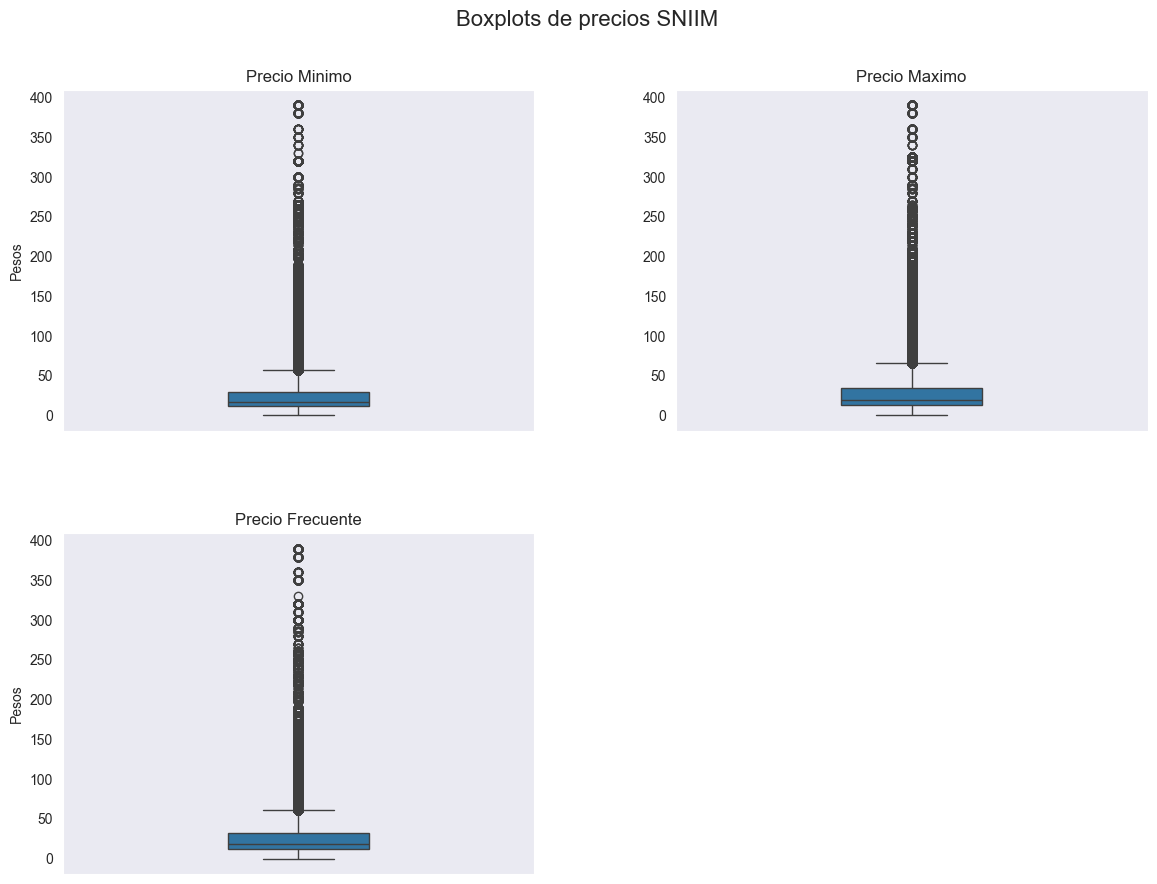

In [58]:
# Fijamos estilo
sns.set_style("dark")

# Configurar la figura y los subplots
num_rows = 2
num_cols = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 8))
# Ajustar el espacio entre subplots
fig.subplots_adjust(wspace=0.3, hspace=0.3, bottom=-0.1)

# Asegurarse de que 'axes' sea una matriz 2D
axes = axes.reshape(-1)

# Iterar a través de las columnas numéricas y crear boxplots divididos por HeartDisease
for i, variable in enumerate(VARIABLES_NUMERICAS_SNIIM):
    sns.boxplot(data=df_sniim_orig_cult, y=variable, ax=axes[i], width=0.3)
    axes[i].set_title(f'{variable}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Eliminar la subgráfica vacía 
fig.delaxes(axes[-1])

# Agregar un título general a la figura
fig.suptitle('Boxplots de precios SNIIM', fontsize=16)

axes[0].set_ylabel('Pesos')
axes[2].set_ylabel('Pesos')

# Ajustar el espaciado entre subplots
#plt.tight_layout()

# Mostrar la figura
plt.show()

In [59]:
# # Configurar la figura y los subplots
# num_rows = 2
# num_cols = 3
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 12))
# # Ajustar el espacio entre subplots
# fig.subplots_adjust(wspace=0.3, hspace=0.3, bottom=-0.1)

# # Asegurarse de que 'axes' sea una matriz 2D
# axes = axes.reshape(-1)

# # Iterar a través de las columnas numéricas y crear histogramas de densidad kde
# for i, variable in enumerate(VARIABLES_NUMERICAS_MENSUALES):
#     sns.histplot(data=df_siap, x=variable, kde=True, ax=axes[i])
#     axes[i].set_title(f'{variable}')
#     axes[i].set_xlabel('')
#     axes[i].set_ylabel('')

# # Eliminar la subgráfica vacía correspondiente a la variable FastingBS
# fig.delaxes(axes[-1])

# # Agregar un título general a la figura
# fig.suptitle('Distribuciones de densidad de variables mensuales SIAP', fontsize=16)

# axes[0].set_ylabel('Hectáreas')
# axes[3].set_ylabel('Toneladas')
# axes[4].set_ylabel('Tonelada / Hectárea')

# # Ajustar el espaciado entre subplots
# #plt.tight_layout()

# # Mostrar la figura
# plt.show()

#### Método Local Factor Outlier

In [60]:
# Crear modelo 
clf = LocalOutlierFactor(n_neighbors=20)

# Quitar columnas cualitativas 
X = df_sniim_orig_cult.drop(columns=['Fecha', 'Origen', 'Destino', 'Cultivo SIAP'])

# Buscar outliers
estimado_LOF = clf.fit_predict(X)

# Contar y mostrar resultados
cantidad_outliers_LOF = abs(estimado_LOF[estimado_LOF==-1].sum())
porcentaje_outliers_LOF = cantidad_outliers_LOF / len(df_sniim_orig_cult) * 100

print(f"Cantidad de outliers: {cantidad_outliers_LOF}")
print(f"Porcentaje con respecto al total de datos: {porcentaje_outliers_LOF:.2f}%")

Cantidad de outliers: 25717
Porcentaje con respecto al total de datos: 8.99%


Inspeccionamos algunos datos outlier según Local Factor Outlier

In [61]:
# Obtener datos outlier según LOF
outliers_LOF = df_sniim_orig_cult[(estimado_LOF==-1)]

# Inspeccionar muestras de outliers
outliers_LOF.sample(n=10)

,Fecha,Origen,Destino,Cultivo SIAP,Precio Minimo,Precio Maximo,Precio Frecuente
222035,2023-01-26,Baja California,"Baja California : Central de Abasto INDIA, Tij...",Cebolla,9.135000,9.135000,9.135000
66124,2020-12-18,Baja California,Baja California Sur: Unión de Comerciantes de ...,Lechuga,12.500000,21.855000,15.000000
132845,2021-11-17,Veracruz,DF: Central de Abasto de Iztapalapa DF,Naranja,4.800000,6.800000,5.100000
91126,2021-05-03,Baja California,Baja California Sur: Unión de Comerciantes de ...,Lechuga,14.165000,21.855000,14.165000
271014,2023-08-18,Jalisco,Baja California Sur: Unión de Comerciantes de ...,Limón,28.400000,28.400000,28.400000
155994,2022-03-10,Ciudad de México,México: Central de Abasto de Ecatepec,Uva,67.500000,75.000000,75.000000
228691,2023-02-22,Oaxaca,"Sonora: Mercado de Abasto ""Francisco I. Madero...",Piña,21.820000,25.000000,25.000000
244282,2023-04-28,Ciudad de México,"Campeche: Mercado ""Pedro Sáinz de Baranda"", Ca...",Chile verde,30.666667,35.000000,33.333333
181861,2022-07-11,Guerrero,DF: Central de Abasto de Iztapalapa DF,Mango,16.965000,21.430000,18.930000
260597,2023-07-06,Importación,"Baja California : Central de Abasto INDIA, Tij...",Manzana,32.963333,32.963333,32.963333


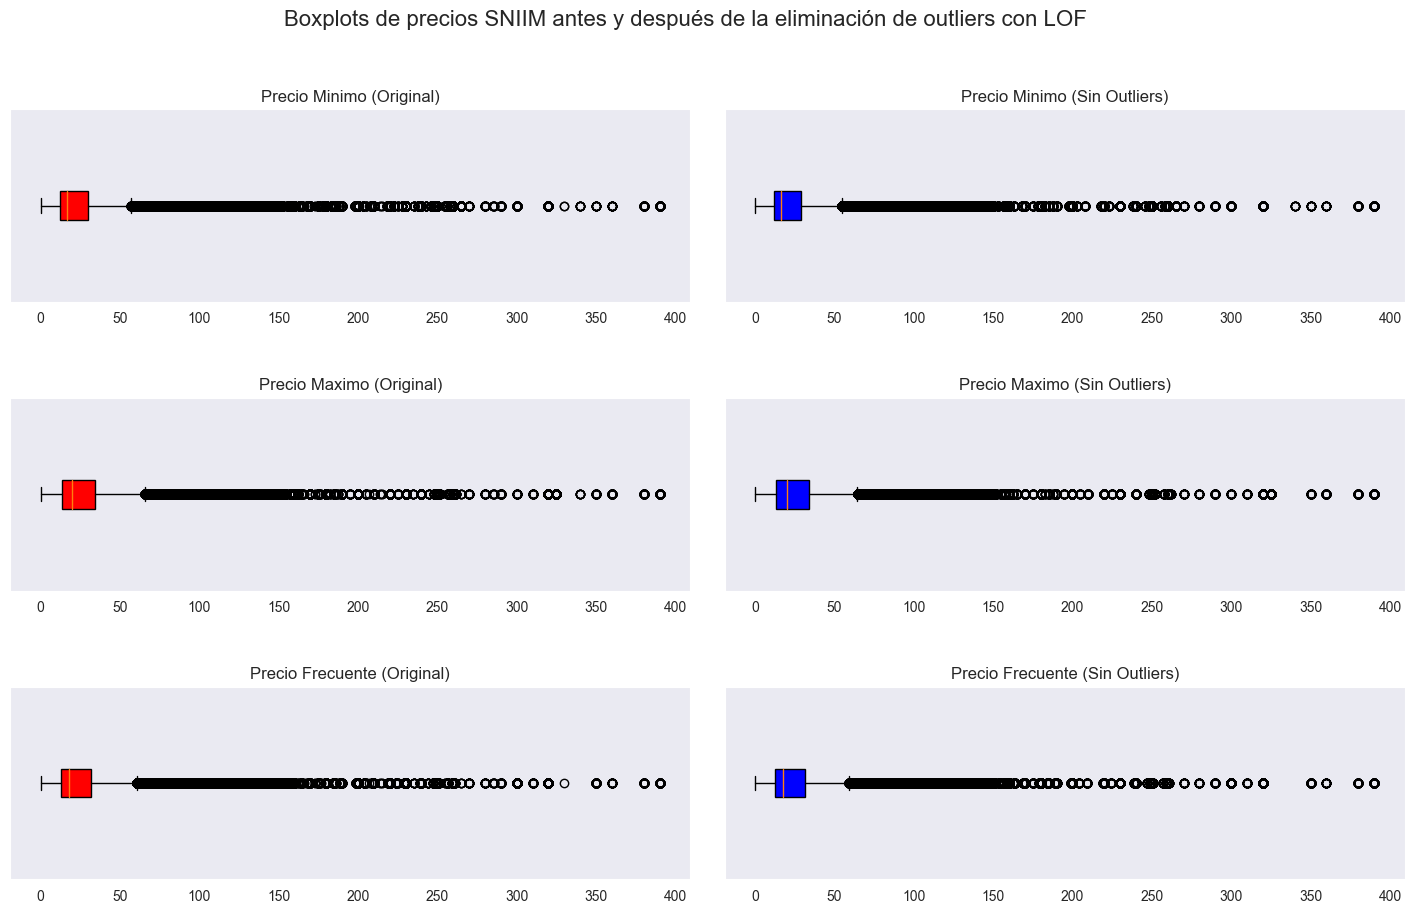

In [62]:
# Eliminar outliers del DataFrame
df_clean_LOF = df_sniim_orig_cult[~(estimado_LOF==-1)]

# Configurar la figura y los subplots con orientación horizontal
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 10))

# Iterar a través de las columnas numéricas y crear boxplots horizontales
for i, variable in enumerate(VARIABLES_NUMERICAS_SNIIM):
    # Boxplot original en rojo con relleno rojo
    axes[i, 0].boxplot(df_sniim_orig_cult[variable], vert=False, patch_artist=True, boxprops=dict(facecolor='red'))
    axes[i, 0].set_title(f'{variable} (Original)')

    # Boxplot sin outliers en azul con relleno azul
    axes[i, 1].boxplot(df_clean_LOF[variable], vert=False, patch_artist=True, boxprops=dict(facecolor='blue'))
    axes[i, 1].set_title(f'{variable} (Sin Outliers)')

    # Eliminar las etiquetas en la columna de la derecha
    axes[i, 0].set_yticklabels([])
    axes[i, 1].set_yticklabels([])

# Ajustar el espaciado entre subplots
#plt.tight_layout()

# Agregar un título general a la figura
fig.suptitle('Boxplots de precios SNIIM antes y después de la eliminación de outliers con LOF', fontsize=16)

# Ajustar el espaciado entre subplots verticalmente
plt.subplots_adjust(hspace=.5, wspace=0.05)

# Mostrar la figura
plt.show()

#### Método Isolation Forest

In [63]:
# Crear modelo Isolation Forest
random_state = np.random.RandomState(42)
clf = IsolationForest(n_estimators=100,max_samples='auto',random_state=random_state)  # Puedes ajustar el parámetro de contaminación según tus necesidades

# Quitar columnas cualitativas 
X = df_sniim_orig_cult.drop(columns=['Fecha', 'Origen', 'Destino', 'Cultivo SIAP'])

# Entrenar el modelo y predecir outliers
estimado_IF = clf.fit_predict(X)

# Contar y mostrar resultados
cantidad_outliers_IF = len(estimado_IF[estimado_IF == -1])
porcentaje_outliers_IF = cantidad_outliers_IF / len(df_sniim_orig_cult) * 100

print(f"Cantidad de outliers: {cantidad_outliers_IF}")
print(f"Porcentaje con respecto al total de datos: {porcentaje_outliers_IF:.2f}%")

Cantidad de outliers: 48582
Porcentaje con respecto al total de datos: 16.98%


Inspeccionamos algunos datos outlier según Isolation Forest

In [64]:
# Obtener datos outlier según IF
outliers_IF = df_sniim_orig_cult[(estimado_IF==-1)]

# Inspeccionar muestras de outliers
outliers_IF.sample(n=20)

,Fecha,Origen,Destino,Cultivo SIAP,Precio Minimo,Precio Maximo,Precio Frecuente
262926,2023-07-17,Colima,Baja California Sur: Unión de Comerciantes de ...,Papaya,16.00,40.000,40.00
248039,2023-05-16,Nayarit,Nayarit: Nayarabastos de Tepic,Zarzamora,79.00,81.000,80.00
217126,2023-01-05,Sinaloa,Michoacán: Mercado de Abasto de Morelia,Chile verde,80.00,100.000,100.00
226446,2023-02-14,Jalisco,Baja California Sur: Unión de Comerciantes de ...,Uva,50.00,87.500,75.00
31331,2020-05-11,Importación,Jalisco: Mercado de Abasto de Guadalajara,Uva,70.00,71.875,70.00
202609,2022-10-20,Ciudad de México,DF: Central de Abasto de Iztapalapa DF,Nopalitos,1.70,1.800,1.70
130493,2021-11-04,Nayarit,Nayarit: Mercado de abasto 'Adolfo López Mateo...,Espárrago,145.00,147.000,146.00
113397,2021-08-11,Nayarit,Nayarit: Nayarabastos de Tepic,Nuez,198.00,200.000,199.00
249574,2023-05-23,Baja California Sur,Baja California Sur: Unión de Comerciantes de ...,Chile verde,10.00,50.000,50.00
243003,2023-04-24,Nayarit,Nayarit: Mercado de abasto 'Adolfo López Mateo...,Chile verde,108.00,110.000,109.00


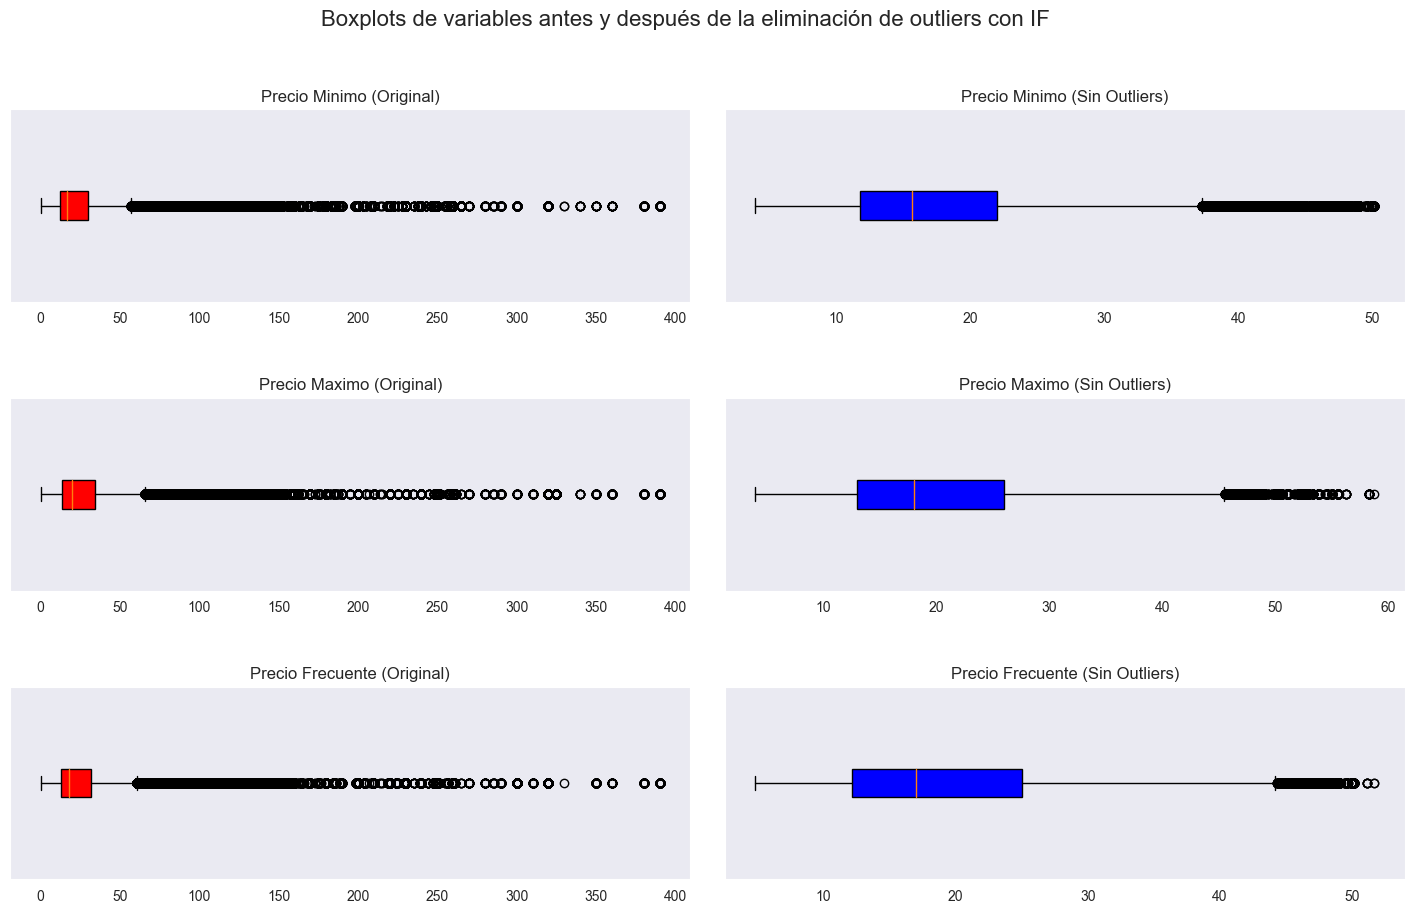

In [65]:
# Eliminar outliers del DataFrame
df_clean_IF = df_sniim_orig_cult[~(estimado_IF==-1)]

# Configurar la figura y los subplots con orientación horizontal
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 10))

# Iterar a través de las columnas numéricas y crear boxplots horizontales
for i, variable in enumerate(VARIABLES_NUMERICAS_SNIIM):
    # Boxplot original en rojo con relleno rojo
    axes[i, 0].boxplot(df_sniim_orig_cult[variable], vert=False, patch_artist=True, boxprops=dict(facecolor='red'))
    axes[i, 0].set_title(f'{variable} (Original)')

    # Boxplot sin outliers en azul con relleno azul
    axes[i, 1].boxplot(df_clean_IF[variable], vert=False, patch_artist=True, boxprops=dict(facecolor='blue'))
    axes[i, 1].set_title(f'{variable} (Sin Outliers)')

    # Eliminar las etiquetas en la columna de la derecha
    axes[i, 0].set_yticklabels([])
    axes[i, 1].set_yticklabels([])

# Ajustar el espaciado entre subplots
#plt.tight_layout()

# Agregar un título general a la figura
fig.suptitle('Boxplots de variables antes y después de la eliminación de outliers con IF', fontsize=16)

# Ajustar el espaciado entre subplots verticalmente
plt.subplots_adjust(hspace=0.5, wspace=0.05)

# Mostrar la figura
plt.show()

En ambos casos, la inspección de los outliers putativos no nos permite identificarlos como verdaderamente valores atípicos. Es normal que ciertos cultivos, como la nuez, se mantengan con precios muy por encima de otros cultivos.

## Relaciones entre variables por visualización

In [66]:
# Magic command para hacer gráficas interactivas
#%matplotlib widget

### Análisis temporal: ¿En qué épocas del año es más probable que se generen excedentes? 

Analizamos la evolución de las variables númericas a lo largo de los años, para cada uno de los cultivos de interés. Para esto, vamos a ignorar la información geográfica, promediando los valores a lo largo de todos los municipios y estados. Hacemos esto para las variables mensuales y acumuladas del SIAP por un lado, y para los precios del SNIIM por el otro.

In [67]:
#SIAP mensual

# Sumamos los valores de todos los municipios y estados, agrupados por año, mes y cultivo
df_siap_año_mes_cult = df_siap.groupby(['Año', 'Mes', 'Cultivo'])[VARIABLES_NUMERICAS_SIAP[:5]].sum().reset_index()

#SIAP acumulado

# Sumamos los valores de todos los municipios y estados, agrupados por año, mes y cultivo
df_siap_año_mes_cult_cum = df_siap.groupby(['Año', 'Mes', 'Cultivo'])[VARIABLES_NUMERICAS_SIAP[5:]].sum().reset_index()

# SNIIM mensual

df_sniim_año_mes_cult = df_sniim_orig_cult_mes.groupby(['Año', 'Mes', 'Cultivo SIAP'])[VARIABLES_NUMERICAS_SNIIM].mean().reset_index()

In [68]:
# Inspeccionar agrupamiento SIAP
df_siap_año_mes_cult.head()

,Año,Mes,Cultivo,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion,Rendimiento
0,2020,Enero,Berenjena,1501.86,1083.23,0.0,50678.27,208.30
1,2020,Enero,Brócoli,14945.06,1552.31,0.0,24946.08,465.74
2,2020,Enero,Calabacita,0.00,0.00,0.0,0.00,0.00
3,2020,Enero,Cebolla,18665.86,3440.00,0.0,54117.52,378.11
4,2020,Enero,Chile verde,30093.30,8824.70,50.5,254457.15,637.69


In [69]:
# Inspeccionar agrupamiento SIAP acumulado
df_siap_año_mes_cult_cum.head()

,Año,Mes,Cultivo,Superficie Sembrada Acumulada,Superficie Cosechada Acumulada,Superficie Siniestrada Acumulada,Produccion Acumulada
0,2020,Enero,Berenjena,1501.86,1083.23,0.0,50678.27
1,2020,Enero,Brócoli,14945.06,1552.31,0.0,24946.08
2,2020,Enero,Calabacita,0.00,0.00,0.0,0.00
3,2020,Enero,Cebolla,18665.86,3440.00,0.0,54117.52
4,2020,Enero,Chile verde,30093.30,8824.70,50.5,254457.15


In [70]:
# Inspeccionar agrupamiento SNIIM
df_sniim_año_mes_cult.head()

,Año,Mes,Cultivo SIAP,Precio Minimo,Precio Maximo,Precio Frecuente
0,2020,Abril,Berenjena,21.394737,24.315789,22.684211
1,2020,Abril,Brócoli,14.162667,17.029333,16.150167
2,2020,Abril,Calabacita,12.786066,14.218066,13.226230
3,2020,Abril,Cebolla,12.418579,14.446115,13.093476
4,2020,Abril,Chile verde,36.476836,40.412747,38.589654


In [71]:
# Función para obtener la etiqueta del eje y según el tipo de variable
def get_label(variable):
    if variable in ['Superficie Sembrada', 'Superficie Cosechada', 'Superficie Siniestrada', 'Superficie Sembrada Acumulada', 'Superficie Cosechada Acumulada', 'Superficie Siniestrada Acumulada'
                    'Superficie Sembrada Anual', 'Superficie Cosechada Anual', 'Superficie Siniestrada Anual']:
        return 'Hectáreas'
    elif variable in ['Precio Minimo', 'Precio Maximo', 'Precio Frecuente', 'Precio Minimo Anual', 'Precio Maximo Anual', 'Precio Frecuente Anual']:
        return 'Pesos'
    elif variable in ['Produccion', 'Produccion Acumulada', 'Produccion Anual']:
        return 'Toneladas'
    elif variable in ['Rendimiento', 'Rendimiento Anual']:
        return 'Tonelada/Hectárea'
    else:
        return ''

In [72]:
# Fijamos estilo
sns.set_style("white")

# Función para actualizar el gráfico según el cultivo y variable seleccionados
def update_plot(cultivo, variable):
    plt.figure(figsize=(12, 8))

    if cultivo == 'Todos los cultivos':
        # Seleccionar el DataFrame correspondiente según la variable
        if variable in VARIABLES_NUMERICAS_SIAP:
            data = df_siap_año_mes_cult
        elif variable in VARIABLES_NUMERICAS_SNIIM:
            data = df_sniim_año_mes_cult
        else:
            # Manejar el caso en que la variable no pertenezca a ninguno de los dos DataFrames
            raise ValueError(f"La variable {variable} no es válida.")
        
        # Graficar la producción promedio de todos los cultivos
        sns.barplot(x='Mes', y=variable, hue='Año', data=data, palette=COLORES, ci=False, estimator='mean')
        title = f'{variable} promedio de Todos los Cultivos por mes y año'
    else:
        # Seleccionar el DataFrame correspondiente según la variable y cultivo
        if variable in VARIABLES_NUMERICAS_SIAP:
            data = df_siap_año_mes_cult[df_siap_año_mes_cult['Cultivo'] == cultivo]
        elif variable in VARIABLES_NUMERICAS_SNIIM:
            data = df_sniim_año_mes_cult[df_sniim_año_mes_cult['Cultivo SIAP'] == cultivo]
        else:
            # Manejar el caso en que la variable no pertenezca a ninguno de los dos DataFrames
            raise ValueError(f"La variable {variable} no es válida.")
        
        # Graficar la producción del cultivo seleccionado
        sns.barplot(x='Mes', y=variable, hue='Año', data=data, palette=COLORES, ci=False)
        title = f'{variable} de {cultivo} por mes y año'

    # Añadir título y etiquetas a los ejes
    plt.title(title)
    plt.xlabel('Mes')

    # Añadir label y dinámico al eje y
    plt.ylabel(get_label(variable))

    # Mostrar la leyenda
    plt.legend(title='Año', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Mostrar el gráfico
    plt.show()

# Añadir la opción "Todos los cultivos" a la lista de cultivos
cultivos_unicos = ['Todos los cultivos'] + CULTIVOS_UNICOS

# Crear los widgets de selección
cultivo_selector = widgets.Dropdown(options=cultivos_unicos, value='Todos los cultivos', description='Cultivo')
variable_selector = widgets.Dropdown(options=VARIABLES_NUMERICAS_SIAP[:4] + VARIABLES_NUMERICAS_SNIIM, value='Produccion', description='Variable')

# Crear la interfaz interactiva
interact(update_plot, cultivo=cultivo_selector, variable=variable_selector)


interactive(children=(Dropdown(description='Cultivo', options=('Todos los cultivos', 'Berenjena', 'Brócoli', '…

<function __main__.update_plot(cultivo, variable)>

Para facilitar el análisis comparativo entre los distintos años, repetimos la gráfica pero ahora de manera acumulada. Esto no solo facilita comparar los patrones de evolución a lo largo de cada año, sino que permite comparar los valores totales de cada año simplemente inspeccionando el mes de Diciembre. 

In [73]:
# Fijamos estilo
sns.set_style("white")

# Función para actualizar el gráfico según el cultivo y variable seleccionados
def update_plot(cultivo, variable):
    plt.figure(figsize=(12, 8))

    if cultivo == 'Todos los cultivos':
        # Graficar la producción promedio de todos los cultivos
        sns.barplot(x='Mes', y=variable, hue='Año', data=df_siap_año_mes_cult_cum, palette=COLORES, ci=False, estimator='mean')
        title = f'{variable} Promedio de Todos los Cultivos por mes y año'
    else:
        # Graficar la producción del cultivo seleccionado
        sns.barplot(x='Mes', y=variable, hue='Año', data=df_siap_año_mes_cult_cum[df_siap_año_mes_cult_cum['Cultivo'] == cultivo], palette=COLORES, ci=False)
        title = f'{variable} de {cultivo} por mes y año'

    # Añadir título y etiquetas a los ejes
    plt.title(title)
    plt.xlabel('Mes')

    # Añadir label y dinámico al eje y
    plt.ylabel(get_label(variable))

    # Mostrar la leyenda
    plt.legend(title='Año', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Mostrar el gráfico
    plt.show()

# Crear los widgets de selección
cultivo_selector = widgets.Dropdown(options=cultivos_unicos, value='Todos los cultivos', description='Cultivo')
variable_selector = widgets.Dropdown(options=VARIABLES_NUMERICAS_SIAP[4:], value='Produccion Acumulada', description='Variable')

# Crear la interfaz interactiva
interact(update_plot, cultivo=cultivo_selector, variable=variable_selector)


interactive(children=(Dropdown(description='Cultivo', options=('Todos los cultivos', 'Berenjena', 'Brócoli', '…

<function __main__.update_plot(cultivo, variable)>

Habiendo analizado el patrón de evolución a lo largo de los meses de los distintos años, procedemos a identificar cuáles son, en promedio, los meses con mejores métricas.

In [74]:
# Promediar los valores entre todos los años
df_siap_promedio_anual = df_siap_año_mes_cult.groupby('Mes')[VARIABLES_NUMERICAS_SIAP[:5]].mean().reset_index()
df_sniim_promedio_anual = df_sniim_año_mes_cult.groupby('Mes')[VARIABLES_NUMERICAS_SNIIM].mean().reset_index()

# Función para actualizar el gráfico de barras horizontales según la variable y el cultivo seleccionados
def update_plot(cultivo, variable):
    plt.figure(figsize=(12, 8))

    if cultivo == 'Todos los cultivos':
        # Seleccionar el DataFrame correspondiente según la variable
        if variable in VARIABLES_NUMERICAS_SIAP:
            data = df_siap_promedio_anual
        elif variable in VARIABLES_NUMERICAS_SNIIM:
            data = df_sniim_promedio_anual
        else:
            # Manejar el caso en que la variable no pertenezca a ninguno de los dos DataFrames
            raise ValueError(f"La variable {variable} no es válida.")
        
        # Graficar barras horizontales para el promedio de todos los cultivos
        order = data.groupby('Mes')[variable].mean().sort_values(ascending=False).index
        color_palette = ['limegreen' if i < 3 else 'lightcoral' if i == len(order) - 1 else 'lightgrey' for i in range(len(order))]
        ax = sns.barplot(x=variable, y='Mes', data=data, ci=False, palette=color_palette, order=order)
        title = f'Promedio anual de {variable} para todos los cultivos por mes'
    else:
        # Seleccionar el DataFrame correspondiente según la variable y cultivo
        if variable in VARIABLES_NUMERICAS_SIAP:
            data = df_siap_año_mes_cult[df_siap_año_mes_cult['Cultivo'] == cultivo]
        elif variable in VARIABLES_NUMERICAS_SNIIM:
            data = df_sniim_año_mes_cult[(df_sniim_año_mes_cult['Cultivo SIAP'] == cultivo)]
        else:
            # Manejar el caso en que la variable no pertenezca a ninguno de los dos DataFrames
            raise ValueError(f"La variable {variable} no es válida.")
        
        # Graficar barras horizontales y ordenar los datos directamente en la función de graficado
        order = data.groupby('Mes')[variable].mean().sort_values(ascending=False).index
        color_palette = ['limegreen' if i < 3 else 'lightcoral' if i == len(order) - 1 else 'lightgrey' for i in range(len(order))]
        ax = sns.barplot(x=variable, y='Mes', data=data, ci=False, palette=color_palette, order=order)
        title = f'Promedio anual de {variable} para {cultivo} por mes'

    # Añadir título y etiquetas a los ejes
    plt.title(title, pad=20)
    plt.xlabel(f'{variable} Promedio Anual')
    plt.ylabel('Mes')

    # Añadir label x dinámico
    plt.xlabel(get_label(variable))

    # Eliminar bordes
    plt.gca().spines['left'].set_visible(False)  # Izquierdo
    plt.gca().spines['top'].set_visible(False)   # Superior
    plt.gca().spines['right'].set_visible(False) # Derecho
    plt.gca().spines['bottom'].set_visible(False) # Inferior

    # Eliminar xticks
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    # Añadir valores en la parte superior de las barras
    for p in ax.patches:
        ax.annotate(f'{p.get_width():.2f}', (p.get_width(), p.get_y() + p.get_height() / 2),
                    ha='left', va='center', fontsize=10, color='black')

    # Mostrar el gráfico
    plt.show()

# Crear los widgets de selección
cultivo_selector = widgets.Dropdown(options=cultivos_unicos, value='Todos los cultivos', description='Cultivo')
#cultivo_sniim_selector = widgets.Dropdown(options=cultivos_unicos, value='Todos los cultivos', description='Cultivo SNIIM')
variable_selector = widgets.Dropdown(options=VARIABLES_NUMERICAS_SIAP[:4] + VARIABLES_NUMERICAS_SNIIM, value='Produccion', description='Variable')

# Crear la interfaz interactiva
interact(update_plot, cultivo=cultivo_selector, variable=variable_selector)


interactive(children=(Dropdown(description='Cultivo', options=('Todos los cultivos', 'Berenjena', 'Brócoli', '…

<function __main__.update_plot(cultivo, variable)>

Procedemos a analizar la evolución de las distintas variables numéricas pero ahora a lo largo de todo el periodo del que se tienen datos. Prestamos especial interés a los meses identificados con mejores y peores métricas.

In [75]:
# Creamos una copia de nuestros DataFrames
df_siap_fechas = df_siap.copy()
df_sniim_fechas = df_sniim_orig_cult_mes.copy()

# Asegúrate de tener las columnas Año y Mes en formato string y maneja NaN
df_siap_fechas['Año'] = df_siap_fechas['Año'].astype(str)
df_siap_fechas['Mes'] = df_siap_fechas['Mes'].astype(str)
df_sniim_fechas['Año'] = df_sniim_fechas['Año'].astype(str)
df_sniim_fechas['Mes'] = df_sniim_fechas['Mes'].astype(str)

# Mapea los nombres de los meses a números
meses_dict = {
    'Enero': 1, 'Febrero': 2, 'Marzo': 3, 'Abril': 4, 'Mayo': 5, 'Junio': 6,
    'Julio': 7, 'Agosto': 8, 'Septiembre': 9, 'Octubre': 10, 'Noviembre': 11, 'Diciembre': 12
}

# Mapea los nombres de los meses a números
df_siap_fechas['Mes'] = df_siap_fechas['Mes'].map(meses_dict)
df_sniim_fechas['Mes'] = df_sniim_fechas['Mes'].map(meses_dict)

# Combina las columnas Año y Mes en una nueva columna 'Fecha'
df_siap_fechas['Fecha'] = pd.to_datetime(df_siap_fechas['Año'] + '-' + df_siap_fechas['Mes'].astype(str), format='%Y-%m')
df_sniim_fechas['Fecha'] = pd.to_datetime(df_sniim_fechas['Año'] + '-' + df_sniim_fechas['Mes'].astype(str), format='%Y-%m')

# Agrupa por mes y año y calcula el promedio de las columnas numéricas
df_siap_grouped = df_siap_fechas.groupby(['Fecha', 'Cultivo'])[VARIABLES_NUMERICAS_SIAP[:5]].mean().reset_index()
df_sniim_grouped = df_sniim_fechas.groupby(['Fecha', 'Cultivo SIAP'])[VARIABLES_NUMERICAS_SNIIM].mean().reset_index()

# Filtra los datos para el rango de fechas que deseas
start_date = '2019-12-25'
end_date = '2023-09-10'
df_siap_filtered = df_siap_grouped[(df_siap_grouped['Fecha'] >= start_date) & (df_siap_grouped['Fecha'] <= end_date)]
df_sniim_filtered = df_sniim_grouped[(df_sniim_grouped['Fecha'] >= start_date) & (df_sniim_grouped['Fecha'] <= end_date)]

In [76]:
# Función para graficar
def plot_graph(cultivo, variable):
    plt.subplots(1, 1, figsize=(12, 8))
    
    if cultivo == 'Todos los cultivos':
        # Grafica el promedio de la variable para todos los cultivos
        if variable in VARIABLES_NUMERICAS_SIAP:
            df_all_cultivos_var = df_siap_filtered.groupby('Fecha')[variable].mean().reset_index()
        elif variable in VARIABLES_NUMERICAS_SNIIM:
            df_all_cultivos_var = df_sniim_filtered.groupby('Fecha')[variable].mean().reset_index()
        else:
            raise ValueError(f"La variable {variable} no es válida.")
            
        # Asignar colores según la lista COLORES
        unique_years = df_all_cultivos_var['Fecha'].dt.year.unique()
        color_palette = COLORES[:len(unique_years)]
        
        for i, year in enumerate(unique_years):
            df_year = df_all_cultivos_var[df_all_cultivos_var['Fecha'].dt.year.isin((year, year+1))]
            plt.plot(df_year['Fecha'], df_year[variable], marker='o', linestyle='-', color=color_palette[i], label=f'{year}')

        # Añadir título
        plt.title(f'{variable} de todos los cultivos', pad=30, fontsize=16, fontweight='bold', va='center')

    else:
        # Filtra por el cultivo seleccionado y utiliza el DataFrame correspondiente
        if variable in VARIABLES_NUMERICAS_SIAP:
            df_cultivo = df_siap_filtered[df_siap_filtered['Cultivo'] == cultivo]
        elif variable in VARIABLES_NUMERICAS_SNIIM:
            df_cultivo = df_sniim_filtered[df_sniim_filtered['Cultivo SIAP'] == cultivo]
        else:
            raise ValueError(f"La variable {variable} no es válida.")
        
        # Asignar colores según la lista COLORES
        unique_years = df_cultivo['Fecha'].dt.year.unique()
        color_palette = COLORES[:len(unique_years)]
        
        for i, year in enumerate(unique_years):
            df_year = df_cultivo[df_cultivo['Fecha'].dt.year.isin((year, year+1))]
            plt.plot(df_year['Fecha'], df_year[variable], marker='o', linestyle='-', color=color_palette[i], label=f'{year}')
        
        # Añadir título
        plt.title(f'{variable} de {cultivo}', pad=30)

    # Etiquetas para el eje y
    plt.ylabel(get_label(variable), labelpad=20)

    plt.xlabel('Fecha', labelpad=20)
    plt.tight_layout()
    
    # Fijar el rango del eje x
    plt.xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))
    
    # Añadir leyenda
    plt.legend(title='Año', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

# Crea los widgets interactivos
interact(plot_graph, 
         cultivo=widgets.Dropdown(options=cultivos_unicos, value='Todos los cultivos', description='Cultivo'),
         variable=widgets.Dropdown(options=VARIABLES_NUMERICAS_SIAP[:4] + VARIABLES_NUMERICAS_SNIIM, value='Superficie Sembrada', description='Variable'))


interactive(children=(Dropdown(description='Cultivo', options=('Todos los cultivos', 'Berenjena', 'Brócoli', '…

<function __main__.plot_graph(cultivo, variable)>

Podemos inspeccionar simultaneamente la evolución de las distintas parejas de variables numéricas en busca de alguna relación significativa.

In [77]:
# Función para graficar
def plot_graph(cultivo, variable1, variable2):
    fig, axs = plt.subplots(2, 1, figsize=(12, 12))
    
    if cultivo == 'Todos los cultivos':
        # Grafica el promedio de la variable1 para todos los cultivos
        if variable1 in VARIABLES_NUMERICAS_SIAP:
            df_all_cultivos_var1 = df_siap_filtered.groupby(['Fecha'])[variable1].mean().reset_index()
        elif variable1 in VARIABLES_NUMERICAS_SNIIM:
            df_all_cultivos_var1 = df_sniim_filtered.groupby(['Fecha'])[variable1].mean().reset_index()
        else:
            raise ValueError(f"La variable {variable1} no es válida.")
        
        # Asignar colores a cada año
        for i, year in enumerate(df_all_cultivos_var1['Fecha'].dt.year.unique()):
            df_year = df_all_cultivos_var1[df_all_cultivos_var1['Fecha'].dt.year.isin((year, year + 1))]
            axs[0].plot(df_year['Fecha'], df_year[variable1], marker='o', linestyle='-', color=COLORES[i], label=f'{year}')

        axs[0].legend(loc='upper right')
        axs[0].set_xticks([])  # Elimina las marcas del eje x
        
        # Grafica el promedio de la variable2 para todos los cultivos
        if variable2 in VARIABLES_NUMERICAS_SIAP:
            df_all_cultivos_var2 = df_siap_filtered.groupby(['Fecha'])[variable2].mean().reset_index()
        elif variable2 in VARIABLES_NUMERICAS_SNIIM:
            df_all_cultivos_var2 = df_sniim_filtered.groupby(['Fecha'])[variable2].mean().reset_index()
        else:
            raise ValueError(f"La variable {variable2} no es válida.")
        
        # Asignar colores a cada año
        for i, year in enumerate(df_all_cultivos_var2['Fecha'].dt.year.unique()):
            df_year = df_all_cultivos_var2[df_all_cultivos_var2['Fecha'].dt.year.isin((year, year + 1))]
            axs[1].plot(df_year['Fecha'], df_year[variable2], marker='o', linestyle='-', color=COLORES[i], label='_')

        axs[1].legend(loc='upper right')
        
        # Calcular la correlación
        corr_value = df_all_cultivos_var1[variable1].corr(df_all_cultivos_var2[variable2])
        # Añadir el valor de correlación como texto en la figura
        fig.text(1.07, 0.505, f'Corr: {corr_value:.2f}', ha='center', va='center', fontsize=18, fontweight='bold')

        # Añadir título superior
        suptitle = f'{variable1} vs {variable2} de {cultivo}'
        suptitle_obj = fig.suptitle(suptitle, fontsize=16, fontweight='bold', va='center')
        # Ajustar la posición vertical del título superior
        suptitle_obj.set_y(1)

    else:
        # Filtra por el cultivo seleccionado
        if variable1 in VARIABLES_NUMERICAS_SIAP:
            df_cultivo_var1 = df_siap_filtered[df_siap_filtered['Cultivo'] == cultivo].groupby(['Fecha'])[variable1].mean().reset_index()
        elif variable1 in VARIABLES_NUMERICAS_SNIIM:
            df_cultivo_var1 = df_sniim_filtered[df_sniim_filtered['Cultivo SIAP'] == cultivo].groupby(['Fecha'])[variable1].mean().reset_index()
        else:
            raise ValueError(f"La variable {variable1} no es válida.")
        
        # Asignar colores a cada año
        for i, year in enumerate(df_cultivo_var1['Fecha'].dt.year.unique()):
            df_year = df_cultivo_var1[df_cultivo_var1['Fecha'].dt.year.isin((year, year + 1))]
            axs[0].plot(df_year['Fecha'], df_year[variable1], marker='o', linestyle='-', color=COLORES[i], label=f'{year}')

        axs[0].legend(loc='upper right')
        axs[0].set_xticks([])  # Elimina las marcas del eje x
        
        # Filtra por el cultivo seleccionado
        if variable2 in VARIABLES_NUMERICAS_SIAP:
            df_cultivo_var2 = df_siap_filtered[df_siap_filtered['Cultivo'] == cultivo].groupby(['Fecha'])[variable2].mean().reset_index()
        elif variable2 in VARIABLES_NUMERICAS_SNIIM:
            df_cultivo_var2 = df_sniim_filtered[df_sniim_filtered['Cultivo SIAP'] == cultivo].groupby(['Fecha'])[variable2].mean().reset_index()
        else:
            raise ValueError(f"La variable {variable2} no es válida.")
        
        # Asignar colores a cada año
        for i, year in enumerate(df_cultivo_var2['Fecha'].dt.year.unique()):
            df_year = df_cultivo_var2[df_cultivo_var2['Fecha'].dt.year.isin((year, year + 1))]
            axs[1].plot(df_year['Fecha'], df_year[variable2], marker='o', linestyle='-', color=COLORES[i], label='_')
        
        axs[1].legend(loc='upper right')

        # Calcular la correlación
        corr_value = df_cultivo_var1[variable1].corr(df_cultivo_var2[variable2])
        # Añadir el valor de correlación como texto en la figura
        fig.text(1.07, 0.515, f'Corr: {corr_value:.2f}', ha='center', va='center', fontsize=14, fontweight='bold')

        # Añadir título superior
        suptitle = f'{variable1} vs {variable2} de {cultivo}'
        suptitle_obj = fig.suptitle(suptitle, fontsize=16, fontweight='bold', va='center')
        # Ajustar la posición vertical del título superior
        suptitle_obj.set_y(1)

    # Etiquetas para el eje y
    axs[0].set_ylabel(get_label(variable1))
    axs[1].set_ylabel(get_label(variable2))

    plt.xlabel('Fecha')
    plt.tight_layout()
    
    # Fijar el rango del eje x
    plt.xlim(df_siap_filtered['Fecha'].min(), df_siap_filtered['Fecha'].max())
        
    plt.show()

# Crea los widgets interactivos
interact(plot_graph, 
         cultivo=widgets.Dropdown(options=cultivos_unicos, value='Todos los cultivos', description='Cultivo'),
         variable1=widgets.Dropdown(options=VARIABLES_NUMERICAS_SIAP[:4] + VARIABLES_NUMERICAS_SNIIM, value='Superficie Sembrada', description='Variable 1'),
         variable2=widgets.Dropdown(options=VARIABLES_NUMERICAS_SIAP[:4] + VARIABLES_NUMERICAS_SNIIM, value='Superficie Cosechada', description='Variable 2'))


interactive(children=(Dropdown(description='Cultivo', options=('Todos los cultivos', 'Berenjena', 'Brócoli', '…

<function __main__.plot_graph(cultivo, variable1, variable2)>

### Análisis geográfico: ¿En qué ubicaciones es más probable que se generen excedentes? 

Anteriornmente ignoramos la información geográfica de nuestros datos, promediando los valores a lo largo de todo el territorio nacional. A continuación, ahondaremos en la geografía de nuestros datos, con el objetivo de identificar en que localidades es más plausible que se generen excedentes de los distintos cultivos.

Intentando pasar de lo general a lo más específico, como primer paso evaluaremos cómo fluctuan los valores de nuestras distintas variables numéricas en los distintos estados de México.

In [78]:
# SIAP acumulado

# Agrupación para el año 2023 hasta septiembre
df_siap_2023_hasta_septiembre = df_siap[(df_siap['Año'] == 2023) & (df_siap['Mes'] == 'Septiembre')].groupby(['Año', 'Entidad', 'Cultivo'])[VARIABLES_NUMERICAS_SIAP[4:]].sum().reset_index()

# Agrupación para los demás años y diciembre
df_siap_resto = df_siap[~(df_siap['Año'] == 2023) & (df_siap['Mes'] == 'Diciembre')].groupby(['Año', 'Entidad', 'Cultivo'])[VARIABLES_NUMERICAS_SIAP[4:]].sum().reset_index()

# Concatenar los resultados
df_siap_año_est_cult = pd.concat([df_siap_resto, df_siap_2023_hasta_septiembre], ignore_index=True)

# Cambiar el nombre de las columnas
df_siap_año_est_cult.rename(columns={'Superficie Sembrada Acumulada': 'Superficie Sembrada Anual', 'Superficie Cosechada Acumulada': 'Superficie Cosechada Anual', 'Superficie Siniestrada Acumulada': 'Superficie Siniestrada Anual', 'Produccion Acumulada': 'Produccion Anual', 'Rendimiento':'Rendimiento Anual'}, inplace=True)

# SNIIM mensual

# Promediamos los valores de todos los municipios y meses, agrupados por año, estado y cultivo
df_sniim_año_est_cult = df_sniim_orig_cult_mes.groupby(['Año', 'Origen', 'Cultivo SIAP'])[VARIABLES_NUMERICAS_SNIIM].mean().reset_index()

# Cambiar el nombre de la columnas
df_sniim_año_est_cult.rename(columns={'Precio Maximo': 'Precio Maximo Anual', 'Precio Minimo': 'Precio Minimo Anual', 'Precio Frecuente': 'Precio Frecuente Anual'}, inplace=True)


In [79]:
# Inspeccionar agrupamiento SIAP
df_siap_año_est_cult.head()

,Año,Entidad,Cultivo,Rendimiento Anual,Superficie Sembrada Anual,Superficie Cosechada Anual,Superficie Siniestrada Anual,Produccion Anual
0,2020,Aguascalientes,Brócoli,140.69,914.00,914.00,0.0,16345.51
1,2020,Aguascalientes,Cebolla,206.67,451.50,451.50,0.0,14016.76
2,2020,Aguascalientes,Chile verde,243.23,878.65,878.65,0.0,17920.50
3,2020,Aguascalientes,Coliflor,102.95,269.00,269.00,0.0,7519.00
4,2020,Aguascalientes,Durazno,86.55,387.75,331.55,0.0,7701.09


In [80]:
# Inspeccionar agrupamiento SNIIM
df_sniim_año_est_cult.head()

,Año,Origen,Cultivo SIAP,Precio Minimo Anual,Precio Maximo Anual,Precio Frecuente Anual
0,2020,Aguascalientes,Berenjena,38.000000,40.000000,39.000000
1,2020,Aguascalientes,Brócoli,8.870558,10.558376,9.708122
2,2020,Aguascalientes,Calabacita,14.529933,15.441116,15.092594
3,2020,Aguascalientes,Coliflor,8.624365,10.624365,9.624365
4,2020,Aguascalientes,Guayaba,8.856396,10.025178,9.439086


Utilizamos geopandas para graficar sobre un mapa de México empleando un mapa de calor

In [81]:
# Cargamos los datos con la información geográfica
df_geo = geopandas.read_file("https://gist.githubusercontent.com/walkerke/76cb8cc5f949432f9555/raw/363c297ce82a4dcb9bdf003d82aa4f64bc695cf1/mx.geojson")

# Inspeccionamos los datos
df_geo.head()

,id,name,state,mus09,pri10,sec10,ter10,gdp08,other10,geometry
0,1,Aguascalientes,Aguascalientes,17.1,6.34,28.74,64.28,84.70,0.64,"MULTIPOLYGON (((-102.21140 22.35450, -102.1908..."
1,2,Baja California,Baja California,15.4,5.44,31.64,61.68,83.07,1.24,"MULTIPOLYGON (((-114.09429 28.02418, -114.0774..."
2,3,Baja California Sur,Baja California Sur,3.0,9.18,17.48,72.37,94.64,0.97,"MULTIPOLYGON (((-109.79843 24.15516, -109.8028..."
3,4,Campeche,Campeche,7.0,19.24,21.20,57.11,395.55,2.45,"MULTIPOLYGON (((-91.52440 18.76659, -91.52457 ..."
4,5,Chiapas,Chiapas,13.9,42.76,13.51,42.90,34.44,0.83,"MULTIPOLYGON (((-93.97061 16.00979, -93.96390 ..."


In [82]:
# Evaluamos qué nombres de estado en el sniim no están en el siap
print('Estados del SNIIM no presentes en el SIAP:\n')
for estado_geo in df_geo['name'].unique():
    if estado_geo not in df_siap['Entidad'].unique():
        print(estado_geo)

Estados del SNIIM no presentes en el SIAP:

Distrito Federal


In [83]:
# Crear copia del dataframe
df_geo_name = df_geo.copy()

# Reemplazamos Distrito Federal por Ciudad de México
condicion = df_geo_name['name'] == "Distrito Federal"
df_geo_name.loc[condicion, 'name'] = "Ciudad de México" 

In [84]:
# # Obtener la lista de cultivos únicos
# cultivos_unicos = ['Todos los cultivos'] + CULTIVOS_UNICOS

# # Fuera de la función
# df_siap_est = df_siap_año_est_cult.groupby('Entidad')[VARIABLES_NUMERICAS_SIAP[4:]].mean().reset_index()

# # Dentro de la función
# def plot_map(cultivo_seleccionado, variable_seleccionada):
#     if cultivo_seleccionado == 'Todos los cultivos':
#         gdf = df_geo.merge(df_siap_est, left_on='name', right_on='Entidad', how='left')
#     else:
#         gdf_cultivo = df_siap_año_est_cult[df_siap_año_est_cult['Cultivo'] == cultivo_seleccionado]
#         gdf = df_geo.merge(gdf_cultivo, left_on='name', right_on='Entidad', how='left')

#     # Rellenar los valores nulos con 0
#     gdf[variable_seleccionada] = gdf[variable_seleccionada].fillna(0)

#     # Crear un mapa de calor con escala ajustada
#     fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
#     # Verificar si se trata de 'Todos los cultivos'
#     if cultivo_seleccionado == 'Todos los cultivos':
#         gdf.plot(column=variable_seleccionada, ax=ax, legend=True, cmap='YlOrRd')
#     else:
#         gdf.plot(column=variable_seleccionada, ax=ax, legend=True, cmap='YlOrRd')

#     # Dibujar las fronteras del GeoDataFrame con bordes negros y delgados
#     gdf.boundary.plot(ax=ax, color='black', linewidth=0.5)

#     # Personalizar el mapa
#     ax.set_title(f"{variable_seleccionada} por estado ({cultivo_seleccionado})")
#     ax.set_axis_off()

#     # Añadir leyenda si existe
#     legend = ax.get_legend()
#     if legend:
#         legend.set_title(variable_seleccionada)
    
#     # Mostrar el mapa
#     plt.show()

# # Crear el widget interactivo
# interact(plot_map, 
#          cultivo_seleccionado=widgets.Dropdown(options=cultivos_unicos, value='Todos los cultivos', description='Cultivo'),
#          variable_seleccionada=widgets.Dropdown(options=VARIABLES_NUMERICAS_SIAP[4:], value='Produccion Acumulada', description='Variable'))

In [85]:
# Obtener la lista de variables numéricas de ambos dataframes
variables_siap = ['Superficie Sembrada Anual', 'Superficie Cosechada Anual', 'Superficie Siniestrada Anual', 'Produccion Anual', 'Rendimiento Anual']
variables_sniim = ['Precio Minimo Anual', 'Precio Maximo Anual', 'Precio Frecuente Anual']

# Función para graficar el mapa
def plot_map(cultivo_seleccionado, variable_seleccionada_siap, variable_seleccionada_sniim):
    # Mapa izquierdo (siap)
    if cultivo_seleccionado == 'Todos los cultivos':
        gdf_siap = df_geo.merge(df_siap_año_est_cult.groupby('Entidad')[variable_seleccionada_siap].mean().reset_index(), left_on='name', right_on='Entidad', how='left')
    else:
        gdf_cultivo = df_siap_año_est_cult[df_siap_año_est_cult['Cultivo'] == cultivo_seleccionado]
        gdf_siap = df_geo.merge(gdf_cultivo, left_on='name', right_on='Entidad', how='left')

    # Rellenar los valores nulos con 0
    gdf_siap[variable_seleccionada_siap] = gdf_siap[variable_seleccionada_siap].fillna(0)

    # Crear un mapa de calor con escala ajustada
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))

    # Verificar si se trata de 'Todos los cultivos'
    if cultivo_seleccionado == 'Todos los cultivos':
        gdf_siap.plot(column=variable_seleccionada_siap, ax=ax[0], legend=True, cmap='YlOrRd')
    else:
        gdf_siap.plot(column=variable_seleccionada_siap, ax=ax[0], legend=True, cmap='YlOrRd')

    # Dibujar las fronteras del GeoDataFrame con bordes negros y delgados
    gdf_siap.boundary.plot(ax=ax[0], color='black', linewidth=0.5)

    # Personalizar el mapa
    ax[0].set_title(f"{variable_seleccionada_siap} por estado ({cultivo_seleccionado})")
    ax[0].set_axis_off()

    # Añadir leyenda si existe
    legend_siap = ax[0].get_legend()
    if legend_siap:
        legend_siap.set_title(variable_seleccionada_siap)

    # Mapa derecho (sniim)
    if cultivo_seleccionado == 'Todos los cultivos':
        gdf_sniim = df_geo.merge(df_sniim_año_est_cult.groupby('Origen')[variable_seleccionada_sniim].mean().reset_index(), left_on='name', right_on='Origen', how='left')
    else:
        gdf_cultivo_sniim = df_sniim_año_est_cult[df_sniim_año_est_cult['Cultivo SIAP'] == cultivo_seleccionado]
        gdf_sniim = df_geo.merge(gdf_cultivo_sniim, left_on='name', right_on='Origen', how='left')

    # Rellenar los valores nulos con 0
    gdf_sniim[variable_seleccionada_sniim] = gdf_sniim[variable_seleccionada_sniim].fillna(0)

    # Verificar si se trata de 'Todos los cultivos'
    if cultivo_seleccionado == 'Todos los cultivos':
        gdf_sniim.plot(column=variable_seleccionada_sniim, ax=ax[1], legend=True, cmap='YlOrRd')
    else:
        gdf_sniim.plot(column=variable_seleccionada_sniim, ax=ax[1], legend=True, cmap='YlOrRd')

    # Dibujar las fronteras del GeoDataFrame con bordes negros y delgados
    gdf_sniim.boundary.plot(ax=ax[1], color='black', linewidth=0.5)

    # Personalizar el mapa
    ax[1].set_title(f"{variable_seleccionada_sniim} por estado ({cultivo_seleccionado})")
    ax[1].set_axis_off()

    # Añadir leyenda si existe
    legend_sniim = ax[1].get_legend()
    if legend_sniim:
        legend_sniim.set_title(variable_seleccionada_sniim)

    # Añadir título superior a la figura
    plt.suptitle("Comparación de Variables SIAP vs SNIIM por estado", fontsize=16, y=1)

    # Mostrar el mapa
    plt.show()

# Crear los widgets interactivos
widget_cultivo = widgets.Dropdown(options=cultivos_unicos, value='Todos los cultivos', description='Cultivo')
widget_variable_siap = widgets.Dropdown(options=variables_siap, value="Produccion Anual", description='SIAP')
widget_variable_sniim = widgets.Dropdown(options=variables_sniim, value="Precio Frecuente Anual", description='SNIIM')

# Crear el widget interactivo
interact(plot_map, 
         cultivo_seleccionado=widget_cultivo,
         variable_seleccionada_siap=widget_variable_siap,
         variable_seleccionada_sniim=widget_variable_sniim)


interactive(children=(Dropdown(description='Cultivo', options=('Todos los cultivos', 'Berenjena', 'Brócoli', '…

<function __main__.plot_map(cultivo_seleccionado, variable_seleccionada_siap, variable_seleccionada_sniim)>

Habiendo analizado la distribución de nuestras variables numéricas a lo largo del territorio, podemos buscar a aquellas localidades con valores más elevados para estas variables. 

In [86]:
# Función para actualizar el gráfico de barras horizontales según la variable y el cultivo seleccionados
def update_plot_año_entidad(cultivo, variable):
    plt.figure(figsize=(12, 8))

    if cultivo == 'Todos los cultivos':
        if variable in variables_sniim:
            # Seleccionar el DataFrame correspondiente según la variable
            data = df_sniim_año_est_cult.groupby('Origen')[variables_sniim].mean().reset_index()

            # Graficar barras horizontales para el promedio de todos los cultivos
            order = data.groupby('Origen')[variable].mean().sort_values(ascending=False).index
            color_palette = ['limegreen' if i < 3 else 'lightcoral' if i == len(order) - 1 else 'lightgrey' for i in range(len(order))]
            ax = sns.barplot(x=variable, y='Origen', data=data, ci=False, palette=color_palette, order=order)
            title = f'{variable} promedio de todos los cultivos por entidad'

        elif variable in variables_siap:
            # Seleccionar el DataFrame correspondiente según la variable
            data = df_siap_año_est_cult.groupby('Entidad')[variables_siap].mean().reset_index()

            # Graficar barras horizontales para el promedio de todos los cultivos
            order = data.groupby('Entidad')[variable].mean().sort_values(ascending=False).index
            color_palette = ['limegreen' if i < 3 else 'lightcoral' if i == len(order) - 1 else 'lightgrey' for i in range(len(order))]
            ax = sns.barplot(x=variable, y='Entidad', data=data, ci=False, palette=color_palette, order=order)
            title = f'{variable} promedio de todos los cultivos por entidad'

        else:
            raise ValueError(f"La variable {variable} no es válida.")
    else:
        if variable in variables_sniim:
            # Seleccionar el DataFrame correspondiente según la variable y cultivo
            data = df_sniim_año_est_cult[df_sniim_año_est_cult['Cultivo SIAP'] == cultivo]

            # Graficar barras horizontales y ordenar los datos directamente en la función de graficado
            order = data.groupby('Origen')[variable].mean().sort_values(ascending=False).index
            color_palette = ['limegreen' if i < 3 else 'lightcoral' if i == len(order) - 1 else 'lightgrey' for i in range(len(order))]
            ax = sns.barplot(x=variable, y='Origen', data=data, ci=False, palette=color_palette, order=order)
            title = f'{variable} promedio de {cultivo} por entidad'

        elif variable in variables_siap:
            # Seleccionar el DataFrame correspondiente según la variable y cultivo
            data = df_siap_año_est_cult[(df_siap_año_est_cult['Cultivo'] == cultivo)]

            # Graficar barras horizontales y ordenar los datos directamente en la función de graficado
            order = data.groupby('Entidad')[variable].mean().sort_values(ascending=False).index
            color_palette = ['limegreen' if i < 3 else 'lightcoral' if i == len(order) - 1 else 'lightgrey' for i in range(len(order))]
            ax = sns.barplot(x=variable, y='Entidad', data=data, ci=False, palette=color_palette, order=order)
            title = f'{variable} promedio de {cultivo} por entidad'

        else:
            raise ValueError(f"La variable {variable} no es válida.")

    # Añadir título y etiquetas a los ejes
    plt.title(title, pad=20)
    plt.xlabel(f'{variable} Promedio Anual')
    plt.ylabel('Entidad')

    # Añadir label x dinámico
    plt.xlabel(get_label(variable))

    # Eliminar bordes
    plt.gca().spines['left'].set_visible(False)  # Izquierdo
    plt.gca().spines['top'].set_visible(False)   # Superior
    plt.gca().spines['right'].set_visible(False) # Derecho
    plt.gca().spines['bottom'].set_visible(False) # Inferior

    # Eliminar xticks
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    # Añadir valores en la parte superior de las barras
    for p in ax.patches:
        ax.annotate(f'{p.get_width():.2f}', (p.get_width(), p.get_y() + p.get_height() / 2),
                    ha='left', va='center', fontsize=10, color='black')

    # Mostrar el gráfico
    plt.show()

# Crear los widgets de selección
cultivo_selector_año_entidad = widgets.Dropdown(options=['Todos los cultivos'] + list(df_siap_año_est_cult['Cultivo'].unique()), 
                                                value='Todos los cultivos', description='Cultivo')
variable_selector_año_entidad = widgets.Dropdown(options=variables_sniim + variables_siap, value='Produccion Anual', description='Variable')

# Crear la interfaz interactiva
interact(update_plot_año_entidad, cultivo=cultivo_selector_año_entidad, 
         variable=variable_selector_año_entidad)


interactive(children=(Dropdown(description='Cultivo', options=('Todos los cultivos', 'Brócoli', 'Cebolla', 'Ch…

<function __main__.update_plot_año_entidad(cultivo, variable)>

In [87]:
# # Obtener la lista de cultivos únicos
# cultivos_unicos = ['Todos los cultivos'] + CULTIVOS_UNICOS

# # Obtener la lista de variables numéricas de ambos dataframes
# variables_siap = df_siap_año_est_cult.select_dtypes(include='number').columns.tolist()
# variables_sniim = df_sniim_año_est_cult.select_dtypes(include='number').columns.tolist()
# variables_ambos = list(set(variables_siap) | set(variables_sniim))

# # Filtrar variables, excluyendo 'Año'
# variables_unicas = [variable for variable in variables_ambos if variable != 'Año']

In [88]:
# # Función para graficar el mapa
# def plot_map(cultivo_seleccionado, variable_seleccionada):
#     if variable_seleccionada in variables_siap:
#         df_variable = df_siap_año_est_cult[['Entidad', variable_seleccionada]]
#         # Mergear el dataframe de variables con el dataframe geoespacial
#         gdf = df_geo.merge(df_variable, left_on='name', right_on='Entidad', how='left')
#     elif variable_seleccionada in variables_sniim:
#         df_variable = df_sniim_año_est_cult[['Origen', variable_seleccionada]]
#         # Mergear el dataframe de variables con el dataframe geoespacial
#         gdf = df_geo.merge(df_variable, left_on='name', right_on='Origen', how='left')
#     else:
#         raise ValueError(f"La variable seleccionada '{variable_seleccionada}' no es válida.")

#     # Rellenar los valores nulos con 0
#     gdf[variable_seleccionada] = gdf[variable_seleccionada].fillna(0)

#     # Crear un mapa de calor con escala ajustada
#     fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
#     # Verificar si se trata de 'Todos los cultivos'
#     if cultivo_seleccionado == 'Todos los cultivos':
#         gdf.plot(column=variable_seleccionada, ax=ax, legend=True, cmap='YlOrRd')
#     else:
#         # Filtrar por el cultivo seleccionado
#         if variable_seleccionada in variables_siap:
#             gdf_cultivo = df_siap_año_est_cult[df_siap_año_est_cult['Cultivo'] == cultivo_seleccionado]
#             gdf_cultivo = df_geo.merge(gdf_cultivo[['Entidad', variable_seleccionada]], left_on='name', right_on='Entidad', how='left')
#         elif variable_seleccionada in variables_sniim:
#             gdf_cultivo = df_sniim_año_est_cult[df_sniim_año_est_cult['Cultivo SIAP'] == cultivo_seleccionado]
#             gdf_cultivo = df_geo.merge(gdf_cultivo[['Origen', variable_seleccionada]], left_on='name', right_on='Origen', how='left')
#         else:
#             raise ValueError(f"La variable seleccionada '{variable_seleccionada}' no es válida.")
        
#         gdf_cultivo[variable_seleccionada] = gdf_cultivo[variable_seleccionada].fillna(0)
#         gdf_cultivo.plot(column=variable_seleccionada, ax=ax, legend=True, cmap='YlOrRd')

#     # Dibujar las fronteras del GeoDataFrame con bordes negros y delgados
#     gdf.boundary.plot(ax=ax, color='black', linewidth=0.5)

#     # Personalizar el mapa
#     ax.set_title(f"{variable_seleccionada} por estado ({cultivo_seleccionado})")
#     ax.set_axis_off()

#     # Añadir leyenda si existe
#     legend = ax.get_legend()
#     if legend:
#         legend.set_title(variable_seleccionada)
#         # Obtener etiqueta dinámica para la leyenda
#         legend_name = get_label(variable_seleccionada)
#         if legend_name:
#             legend.get_texts()[0].set_text(legend_name)
    
#     # Mostrar el mapa
#     plt.show()

# # Crear los widgets interactivos
# widget_variable = widgets.Dropdown(options=variables_unicas, value=variables_unicas[0], description='Variable')
# widget_cultivo = widgets.Dropdown(options=cultivos_unicos, value='Todos los cultivos', description='Cultivo')

# # Crear el widget interactivo
# interact(plot_map, variable_seleccionada=widget_variable, cultivo_seleccionado=widget_cultivo)


Podemos avanzar ahora a un nivel más específico, analizando los municipios en términos de sus variables SIAP. 

In [89]:
# SIAP acumulado

# Agrupación para el año 2023 hasta septiembre
df_siap_2023_hasta_septiembre = df_siap[(df_siap['Año'] == 2023) & (df_siap['Mes'] == 'Septiembre')].groupby(['Año', 'Entidad', 'Municipio', 'Cultivo'])[VARIABLES_NUMERICAS_SIAP[4:]].sum().reset_index()

# Agrupación para los demás años y diciembre
df_siap_resto = df_siap[~(df_siap['Año'] == 2023) & (df_siap['Mes'] == 'Diciembre')].groupby(['Año', 'Entidad', 'Municipio', 'Cultivo'])[VARIABLES_NUMERICAS_SIAP[4:]].sum().reset_index()

# Concatenar los resultados
df_siap_año_est_mun_cult = pd.concat([df_siap_resto, df_siap_2023_hasta_septiembre], ignore_index=True)

# Volvemos agrupar pero ahora promediando entre años, para obtener un único valor anual promedio por cultivo
df_siap_est_mun_cult = df_siap_año_est_mun_cult.groupby(['Entidad', 'Municipio', 'Cultivo'])[VARIABLES_NUMERICAS_SIAP[4:]].mean().reset_index()

# Cambiar el nombre de las columnas
df_siap_est_mun_cult.rename(columns={'Superficie Sembrada Acumulada': 'Superficie Sembrada Anual', 'Superficie Cosechada Acumulada': 'Superficie Cosechada Anual', 'Superficie Siniestrada Acumulada': 'Superficie Siniestrada Anual', 'Produccion Acumulada': 'Produccion Anual', 'Rendimiento':'Rendimiento Anual'}, inplace=True)

In [90]:
# Inspeccionamos el resultado del agrupamiento 
df_siap_est_mun_cult.head()

,Entidad,Municipio,Cultivo,Rendimiento Anual,Superficie Sembrada Anual,Superficie Cosechada Anual,Superficie Siniestrada Anual,Produccion Anual
0,Aguascalientes,Aguascalientes,Brócoli,17.1975,68.00,66.750,1.25,1137.825
1,Aguascalientes,Aguascalientes,Chile verde,51.8500,7.93,7.930,0.00,392.405
2,Aguascalientes,Aguascalientes,Durazno,16.0700,12.25,11.625,0.00,186.575
3,Aguascalientes,Aguascalientes,Fresa,39.8000,5.00,5.000,0.00,199.000
4,Aguascalientes,Aguascalientes,Frijol,0.3000,257.25,255.750,0.00,101.200


In [91]:
from IPython.display import display

# Función para graficar el treemap
def plot_treemap(cultivo_seleccionado, variable_seleccionada):
    if cultivo_seleccionado == 'Todos los cultivos':
        df_filtered = df_siap_est_mun_cult.groupby(['Entidad', 'Municipio'])[variable_seleccionada].mean().reset_index()
        title = f'Treemap: {variable_seleccionada} promedio de todos los cultivos'
    else:
        df_filtered = df_siap_est_mun_cult[df_siap_est_mun_cult['Cultivo'] == cultivo_seleccionado]
        title = f'Treemap: {variable_seleccionada} promedio de {cultivo_seleccionado}'

    # Crear el treemap con plotly express
    fig = px.treemap(df_filtered,
                     path=['Entidad', 'Municipio'],
                     values=variable_seleccionada,
                     title=title,
                     width=1000, height=800)

    return fig

# Crear los widgets interactivos
widget_cultivo = widgets.Dropdown(options=['Todos los cultivos'] + CULTIVOS_UNICOS, value='Todos los cultivos', description='Cultivo')
widget_variable = widgets.Dropdown(options=variables_siap, value='Produccion Anual', description='Variable')

# Crear el treemap inicial
fig = plot_treemap('Todos los cultivos', 'Produccion Anual')

# Mostrar el widget interactivo
@interact(cultivo_seleccionado=widget_cultivo, variable_seleccionada=widget_variable)
def update_plot(cultivo_seleccionado, variable_seleccionada):
    # Actualizar el treemap
    fig = plot_treemap(cultivo_seleccionado, variable_seleccionada)
    # Mostrar el treemap
    display(fig)

interactive(children=(Dropdown(description='Cultivo', options=('Todos los cultivos', 'Berenjena', 'Brócoli', '…

In [92]:
# Función para actualizar el gráfico de barras horizontales según el cultivo, la variable y el estado seleccionados
def update_plot_siap_est_mun(cultivo, variable, estado):
    plt.figure(figsize=(12, 8))

    if cultivo == 'Todos los cultivos':
        # Seleccionar el DataFrame correspondiente según la variable y el estado
        data = df_siap_est_mun_cult[df_siap_est_mun_cult['Entidad'] == estado]
        
        # Filtrar para mostrar solo los primeros 20 municipios
        municipios_top20 = data['Municipio'].value_counts().nlargest(20).index
        data = data[data['Municipio'].isin(municipios_top20)]
        
        # Graficar barras horizontales y ordenar los datos directamente en la función de graficado
        order = data.groupby('Municipio')[variable].mean().sort_values(ascending=False).index
        color_palette = ['limegreen' if i < 3 else 'lightcoral' if i == len(order) - 1 else 'lightgrey' for i in range(len(order))]
        ax = sns.barplot(x=variable, y='Municipio', data=data, ci=False, palette=color_palette, order=order)
        title = f'Promedio de {variable} para {estado} - {cultivo} por municipio (Top 20)'
    else:
        # Seleccionar el DataFrame correspondiente según el cultivo, la variable y el estado
        data = df_siap_est_mun_cult[(df_siap_est_mun_cult['Cultivo'] == cultivo) & (df_siap_est_mun_cult['Entidad'] == estado)]
        
        # Filtrar para mostrar solo los primeros 20 municipios
        municipios_top20 = data['Municipio'].value_counts().nlargest(20).index
        data = data[data['Municipio'].isin(municipios_top20)]
        
        # Graficar barras horizontales y ordenar los datos directamente en la función de graficado
        order = data.groupby('Municipio')[variable].mean().sort_values(ascending=False).index
        color_palette = ['limegreen' if i < 3 else 'lightcoral' if i == len(order) - 1 else 'lightgrey' for i in range(len(order))]
        ax = sns.barplot(x=variable, y='Municipio', data=data, ci=False, palette=color_palette, order=order)
        title = f'{variable} para {estado} - {cultivo} por municipio (Top 20)'

    # Añadir título y etiquetas a los ejes
    plt.title(title, pad=20)
    plt.xlabel(f'{variable} Promedio Acumulado')
    plt.ylabel('Municipio')

    # Añadir label x dinámico
    plt.xlabel(get_label(variable))

    # Eliminar bordes
    plt.gca().spines['left'].set_visible(False)  # Izquierdo
    plt.gca().spines['top'].set_visible(False)   # Superior
    plt.gca().spines['right'].set_visible(False) # Derecho
    plt.gca().spines['bottom'].set_visible(False) # Inferior

    # Eliminar xticks
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    # Añadir valores en la parte superior de las barras
    for p in ax.patches:
        ax.annotate(f'{p.get_width():.2f}', (p.get_width(), p.get_y() + p.get_height() / 2),
                    ha='left', va='center', fontsize=10, color='black')

    # Mostrar el gráfico
    plt.show()

# Crear los widgets de selección
cultivo_selector_siap_est_mun = widgets.Dropdown(options=['Todos los cultivos'] + list(df_siap_est_mun_cult['Cultivo'].unique()), 
                                                 value='Todos los cultivos', description='Cultivo')
variable_selector_siap_est_mun = widgets.Dropdown(options=variables_siap, 
                                                   value='Produccion Anual', description='Variable')
estado_selector_siap_est_mun = widgets.Dropdown(options=list(df_siap_est_mun_cult['Entidad'].unique()), 
                                                 value=df_siap_est_mun_cult['Entidad'].unique()[0], description='Estado')

# Crear la interfaz interactiva
interact(update_plot_siap_est_mun, cultivo=cultivo_selector_siap_est_mun, 
         variable=variable_selector_siap_est_mun, estado=estado_selector_siap_est_mun)


interactive(children=(Dropdown(description='Cultivo', options=('Todos los cultivos', 'Brócoli', 'Chile verde',…

<function __main__.update_plot_siap_est_mun(cultivo, variable, estado)>

### Análisis de cultivos: ¿De qué cultivo es más probable que se generen excedentes? 

In [93]:
# Utilizamos el agrupamiento que obtuvimos con anterioridad 
df_siap_año_est_cult.head()

,Año,Entidad,Cultivo,Rendimiento Anual,Superficie Sembrada Anual,Superficie Cosechada Anual,Superficie Siniestrada Anual,Produccion Anual
0,2020,Aguascalientes,Brócoli,140.69,914.00,914.00,0.0,16345.51
1,2020,Aguascalientes,Cebolla,206.67,451.50,451.50,0.0,14016.76
2,2020,Aguascalientes,Chile verde,243.23,878.65,878.65,0.0,17920.50
3,2020,Aguascalientes,Coliflor,102.95,269.00,269.00,0.0,7519.00
4,2020,Aguascalientes,Durazno,86.55,387.75,331.55,0.0,7701.09


In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact

# Suponiendo que las columnas se llaman 'Año', 'Entidad', 'Cultivo', 'Rendimiento Anual', 'Superficie Sembrada Anual',
# 'Superficie Cosechada Anual', 'Superficie Siniestrada Anual', 'Produccion Anual', 'Precio Minimo Anual',
# 'Precio Maximo Anual', 'Precio Frecuente Anual'
VARIABLES_NUMERICAS_SIAP = ['Rendimiento Anual', 'Superficie Sembrada Anual', 'Superficie Cosechada Anual',
                            'Superficie Siniestrada Anual', 'Produccion Anual']

VARIABLES_NUMERICAS_SNIIM = ['Precio Minimo Anual', 'Precio Maximo Anual', 'Precio Frecuente Anual']

# Obtener una lista de todos los estados y años únicos
estados_unicos = df_siap_año_est_cult['Entidad'].unique()
años_unicos = df_siap_año_est_cult['Año'].unique()

# Crear los widgets de selección
estado_selector = widgets.Dropdown(options=['Todos los estados'] + list(estados_unicos),
                                    value='Todos los estados', description='Estado')
variable_selector = widgets.Dropdown(options=VARIABLES_NUMERICAS_SIAP + VARIABLES_NUMERICAS_SNIIM,
                                      value='Produccion Anual', description='Variable')
año_selector = widgets.Dropdown(options=['Todos los años'] + list(años_unicos),
                                 value='Todos los años', description='Año')

# Función para actualizar el gráfico según las selecciones en los widgets
def update_plot(estado, variable, año):
    plt.figure(figsize=(12, 8))

    # Filtrar el DataFrame según las selecciones en los widgets
    if variable in VARIABLES_NUMERICAS_SIAP:
        df_filtered = df_siap_año_est_cult
    else:
        df_filtered = df_sniim_año_est_cult

    if estado != 'Todos los estados':
        if variable in VARIABLES_NUMERICAS_SIAP:
            df_filtered = df_filtered[df_filtered['Entidad'] == estado]
        else: 
            df_filtered = df_filtered[df_filtered['Origen'] == estado]

    if año != 'Todos los años':
        df_filtered = df_filtered[df_filtered['Año'] == año]

    # Seleccionar el DataFrame correspondiente según la variable
    if variable in VARIABLES_NUMERICAS_SIAP:
        data = df_filtered.groupby('Cultivo')[variable].mean().reset_index()
        # Graficar barras horizontales y ordenar los datos descendentemente
        order = data.groupby('Cultivo')[variable].mean().sort_values(ascending=False).index
        color_palette = ['limegreen' if i < 3 else 'lightcoral' if i == len(order) - 1 else 'lightgrey' for i in range(len(order))]
        ax = sns.barplot(x=variable, y='Cultivo', data=data, ci=False, palette=color_palette, order=order)
    else:
        data = df_filtered.groupby('Cultivo SIAP')[variable].mean().reset_index()
        # Graficar barras horizontales y ordenar los datos descendentemente
        order = data.groupby('Cultivo SIAP')[variable].mean().sort_values(ascending=False).index
        color_palette = ['limegreen' if i < 3 else 'lightcoral' if i == len(order) - 1 else 'lightgrey' for i in range(len(order))]
        ax = sns.barplot(x=variable, y='Cultivo SIAP', data=data, ci=False, palette=color_palette, order=order)

    # Añadir título y etiquetas a los ejes
    plt.title(f'{variable} por cultivo', pad=20)
    plt.xlabel(get_label(variable))
    plt.ylabel('Cultivo')

    # Estilo adicional
    sns.despine(left=True, bottom=True)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.xticks([])  # Eliminar xticks
    plt.yticks(fontsize=10)  # Ajustar el tamaño de yticks

    # Añadir valores en la parte superior de las barras
    for p in ax.patches:
        ax.annotate(f'{p.get_width():.2f}', (p.get_width(), p.get_y() + p.get_height() / 2),
                    ha='left', va='center', fontsize=10, color='black')

    # Mostrar el gráfico
    plt.show()

# Crear la interfaz interactiva
interact(update_plot, estado=estado_selector, variable=variable_selector, año=año_selector)



interactive(children=(Dropdown(description='Estado', options=('Todos los estados', 'Aguascalientes', 'Baja Cal…

<function __main__.update_plot(estado, variable, año)>

## PCA SIAP

In [117]:
# Seleccionar solo las columnas de interés
selected_columns = ['Superficie Sembrada', 'Superficie Cosechada', 'Superficie Siniestrada', 'Produccion', 'Rendimiento']
df_selected = df_siap[selected_columns]

# Crear un objeto PCA y ajustarlo a los datos
n_components = 2
pca = PCA(n_components=n_components)

pca.fit(df_selected)

# Obtener las componentes principales y la varianza explicada
principal_components = pca.transform(df_selected)
explained_variance = pca.explained_variance_ratio_

# Crear un nuevo DataFrame con las componentes principales
columns = [f'PC{i+1}' for i in range(principal_components.shape[1])]
df_pca = pd.DataFrame(data=principal_components, columns=columns)

# Imprimir el DataFrame con las componentes principales
print(df_pca)

# Imprimir la varianza explicada por cada componente principal
print("\nVarianza explicada por cada componente principal:\n")
print(explained_variance)

               PC1        PC2
0      -350.436451 -20.619926
1      -350.503300 -25.491472
2      -350.538062 -28.024676
3      -349.741212  30.044150
4      -300.867817 -15.300625
...            ...        ...
377932 -335.417719 -28.260620
377933 -350.543255 -28.414706
377934 -350.543410 -28.414400
377935 -350.543410 -28.414400
377936 -350.543410 -28.414400

[377937 rows x 2 columns]

Varianza explicada por cada componente principal:

[0.93082897 0.03888509]


Uniremos nuestros dataframes para tenerlo todo en uno y graficar en base a este. Primero validemos que tengan el mismo tamaño para despues proceder a realizar un merge en base al index de estos dos dataframes.



In [118]:
df_pca.shape

(377937, 2)

In [119]:
df_siap.shape

(377937, 14)

In [120]:

df_siap_pca = pd.merge(df_siap, df_pca, left_index=True, right_index=True)

df_siap_pca.head()

,Entidad,Municipio,Superficie Sembrada Acumulada,Superficie Cosechada Acumulada,Superficie Siniestrada Acumulada,Produccion Acumulada,Rendimiento,Año,Mes,Cultivo,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion,PC1,PC2
359241,Baja California Sur,La Paz,6.0,0.0,0.0,0.0,0.0,2021,Enero,Berenjena,6.0,0.0,0.0,0.0,-350.537205,-28.426636
359242,Baja California Sur,Los Cabos,3.5,0.0,0.0,0.0,0.0,2021,Enero,Berenjena,3.5,0.0,0.0,0.0,-350.537096,-28.426850
359243,Morelos,Miacatlán,0.5,0.0,0.0,0.0,0.0,2021,Enero,Berenjena,0.5,0.0,0.0,0.0,-350.265889,-8.347771
359244,Nayarit,Santiago Ixcuintla,14.0,0.0,0.0,0.0,0.0,2021,Enero,Berenjena,14.0,0.0,0.0,0.0,-350.540736,-28.219538
359245,Quintana Roo,Bacalar,10.0,0.0,0.0,0.0,0.0,2021,Enero,Berenjena,10.0,0.0,0.0,0.0,-349.689566,33.644801


Sustituiremos los valores de la columna Cultivo por el ID que se encuentra en el catalogo de cultivos

In [124]:
cat_cultivo = pd.read_csv('Cultivo.csv').set_index('Name')['ID']
df_siap_pca['Cultivo'] = df_siap_pca['Cultivo'].map(cat_cultivo)

#### Visualización de componentes principales

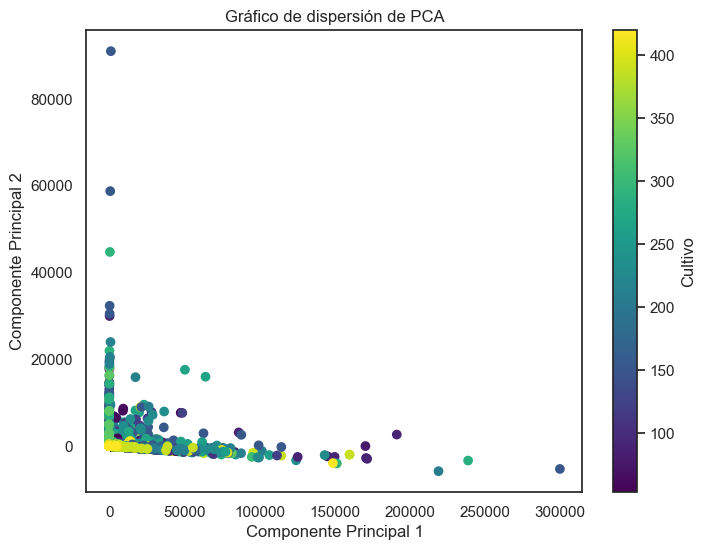

In [125]:
# Supongamos que tus componentes principales se llaman "PC1" y "PC2"
plt.figure(figsize=(8, 6))
plt.scatter(df_siap_pca['PC1'], df_siap_pca['PC2'], c=df_siap_pca['Cultivo'], cmap='viridis')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Gráfico de dispersión de PCA')

plt.colorbar(label='Cultivo')
plt.show()

#### Resultados

La aplicación del PCA resultó en la obtención de dos componentes principales, que representan combinaciones lineales de las variables originales. Además, se obtuvo la varianza explicada por cada componente principal:

| Componente Principal | Varianza     |
|----------------------|--------------|
| PC1                  | 0.99492654   |
| PC2                  | 0.00443579   |

Interpretación de los Componentes Principales:


- **Primer Componente Principal (PC1):** Explica la mayor parte de la variabilidad en los datos, con una varianza cercana al 99.5%. Se presume que este componente puede estar relacionado con las direcciones principales de variabilidad en las variables originales.

- **Segundo Componente Principal (PC2):** Explica una cantidad significativamente menor de la variabilidad total, alrededor del 0.44%. PC2 captura patrones secundarios o menos dominantes en los datos. Aunque su contribución es baja en comparación con PC1, aún podría contener información relevante.

La visualización gráfica revela patrones, aunque su interpretación requeriría la aplicación de diversas técnicas y la consulta de expertos en el tema.

### PCA SNIIM

In [127]:
# Seleccionar solo las columnas de interés
selected_columns = ['Precio Minimo','Precio Maximo', 'Precio Frecuente']
df_selected = df_sniim_orig_cult_mes[selected_columns]

# Crear un objeto PCA y ajustarlo a los datos
n_components = 2
pca = PCA(n_components=n_components)

pca.fit(df_selected)

# Obtener las componentes principales y la varianza explicada
principal_components = pca.transform(df_selected)
explained_variance = pca.explained_variance_ratio_

# Crear un nuevo DataFrame con las componentes principales
columns = [f'PC{i+1}' for i in range(principal_components.shape[1])]
df_pca = pd.DataFrame(data=principal_components, columns=columns)

# Imprimir el DataFrame con las componentes principales
print(df_pca)

# Imprimir la varianza explicada por cada componente principal
print("\nVarianza explicada por cada componente principal:\n")
print(explained_variance)

               PC1       PC2
0       -28.170634 -0.298480
1       -29.913122 -0.724160
2       -26.439068 -0.339173
3       -34.827651 -0.969126
4       -38.560028 -0.054319
...            ...       ...
286031  -23.193636  2.737099
286032  -14.351207 -2.037282
286033  157.073800 -6.065944
286034  -38.560028 -0.054319
286035   -2.723257  1.236141

[286036 rows x 2 columns]

Varianza explicada por cada componente principal:

[0.99337935 0.00537286]


Unión de los datos

In [130]:
print(df_pca.shape)
print(df_sniim_orig_cult_mes.shape)

(286036, 2)
(286036, 9)


In [129]:

df_sniim_pca = pd.merge(df_sniim_orig_cult_mes, df_pca, left_index=True, right_index=True)

#### Visualización de componentes principales

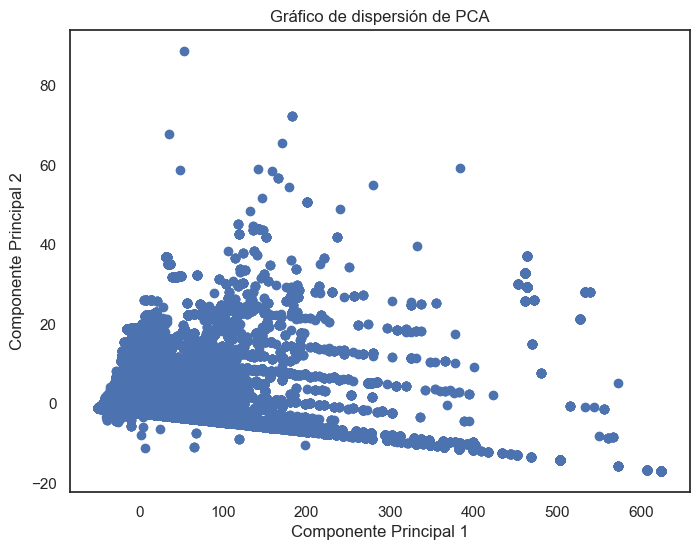

In [134]:
# Supongamos que tus componentes principales se llaman "PC1" y "PC2"
plt.figure(figsize=(8, 6))
plt.scatter(df_sniim_pca['PC1'], df_sniim_pca['PC2'])
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Gráfico de dispersión de PCA')

plt.show()

### Resultados

La aplicación del PCA resultó en la obtención de dos componentes principales, que representan combinaciones lineales de las variables originales. Además, se obtuvo la varianza explicada por cada componente principal:

| Componente Principal | Varianza     |
|----------------------|--------------|
| PC1                  | 0.98890202   |
| PC2                  | 0.00887424   |

Interpretación de los Componentes Principales:

- **Primer Componente Principal (PC1):** Explica la mayor parte de la variabilidad en los datos, con una varianza cercana al 98.9%. Se presume que este componente puede estar relacionado con las direcciones principales de variabilidad en las variables originales.

- **Segundo Componente Principal (PC2):** Explica una cantidad significativamente menor de la variabilidad total, alrededor del 0.89%. PC2 captura patrones secundarios o menos dominantes en los datos. Aunque su contribución es baja en comparación con PC1, aún podría contener información relevante.

La visualización gráfica revela patrones, aunque su interpretación requeriría la aplicación de diversas técnicas y la consulta de expertos en el tema.

### Juntar DataFrames

Debido al no empatamiento de las variables Municipio, por parte de los datos del SIAP, y Destido por parte de los datos del SNIIM, decidimos eliminar estas variables antes de juntar los DataFrames.

In [103]:
# Descartamos la columna Municipio y sumamos aquellos valores que coincidan en Fecha, Estado y Cultivo
df_siap_mun = df_siap.groupby(['Año', 'Mes', 'Entidad', 'Cultivo'])[['Superficie Sembrada Acumulada', 'Superficie Cosechada Acumulada',
                                                                     'Superficie Siniestrada Acumulada', 'Produccion Acumulada',
                                                                     'Rendimiento', 'Superficie Sembrada','Superficie Cosechada', 'Superficie Siniestrada', 'Produccion']].sum().reset_index()

# Descartamos la columna Destino y sumamos aquellos valores que coincidan en Fecha, Estado y Cultivo
df_sniim_orig_cult_mes_dest = df_sniim_orig_cult_mes.groupby(['Año', 'Mes', 'Origen', 'Cultivo SIAP'])[df_sniim_orig_cult_mes.columns[4:7]].sum().reset_index()

In [104]:
# Inspeccionamos los resultados 
df_siap_mun.head()

,Año,Mes,Entidad,Cultivo,Superficie Sembrada Acumulada,Superficie Cosechada Acumulada,Superficie Siniestrada Acumulada,Produccion Acumulada,Rendimiento,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion
0,2020,Enero,Aguascalientes,Berenjena,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
1,2020,Enero,Aguascalientes,Brócoli,440.0,0.0,0.0,0.0,0.00,440.0,0.0,0.0,0.0
2,2020,Enero,Aguascalientes,Calabacita,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
3,2020,Enero,Aguascalientes,Cebolla,247.0,7.0,0.0,128.0,18.29,247.0,7.0,0.0,128.0
4,2020,Enero,Aguascalientes,Chile verde,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0


In [106]:
# Inspeccionamos los resultados 
df_sniim_orig_cult_mes_dest.head()

,Año,Mes,Origen,Cultivo SIAP,Precio Minimo,Precio Maximo,Precio Frecuente
0,2020,Abril,Aguascalientes,Brócoli,190.00,222.00,206.00
1,2020,Abril,Aguascalientes,Calabacita,1377.25,1456.51,1420.80
2,2020,Abril,Aguascalientes,Coliflor,176.00,216.00,196.00
3,2020,Abril,Aguascalientes,Guayaba,166.60,183.40,175.00
4,2020,Abril,Aguascalientes,Lechuga,114.00,140.25,126.75


In [105]:
# Realizar el merge
df_merge = pd.merge(
    df_siap_mun,
    df_sniim_orig_cult_mes_dest,
    how='inner',
    left_on=['Año', 'Mes', 'Entidad', 'Cultivo'],
    right_on=['Año', 'Mes', 'Origen', 'Cultivo SIAP']
)

# Eliminar las columnas duplicadas
df_merge = df_merge.drop(['Origen', 'Cultivo SIAP'], axis=1)

# Mostrar el DataFrame resultante
df_merge

,Año,Mes,Entidad,Cultivo,Superficie Sembrada Acumulada,Superficie Cosechada Acumulada,Superficie Siniestrada Acumulada,Produccion Acumulada,Rendimiento,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion,Precio Minimo,Precio Maximo,Precio Frecuente
0,2020,Enero,Aguascalientes,Brócoli,440.0,0.0,0.0,0.0,0.00,440.0,0.0,0.0,0.0,246.00,290.00,268.00
1,2020,Enero,Aguascalientes,Calabacita,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,1147.76,1232.18,1199.57
2,2020,Enero,Aguascalientes,Coliflor,152.0,0.0,0.0,0.0,0.00,152.0,0.0,0.0,0.0,265.00,309.00,287.00
3,2020,Enero,Aguascalientes,Guayaba,6187.9,0.0,0.0,0.0,0.00,6187.9,0.0,0.0,0.0,192.50,210.85,201.65
4,2020,Enero,Aguascalientes,Lechuga,1468.0,650.0,0.0,23946.0,36.84,1468.0,650.0,0.0,23946.0,118.00,162.00,140.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8418,2023,Octubre,Zacatecas,Cebolla,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,510.00,646.00,646.00
8419,2023,Octubre,Zacatecas,Chile verde,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,458.80,536.80,502.60
8420,2023,Octubre,Zacatecas,Lechuga,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,219.00,219.00,219.00
8421,2023,Octubre,Zacatecas,Tomate verde,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,176.00,228.00,207.00


### Correlación entre variables

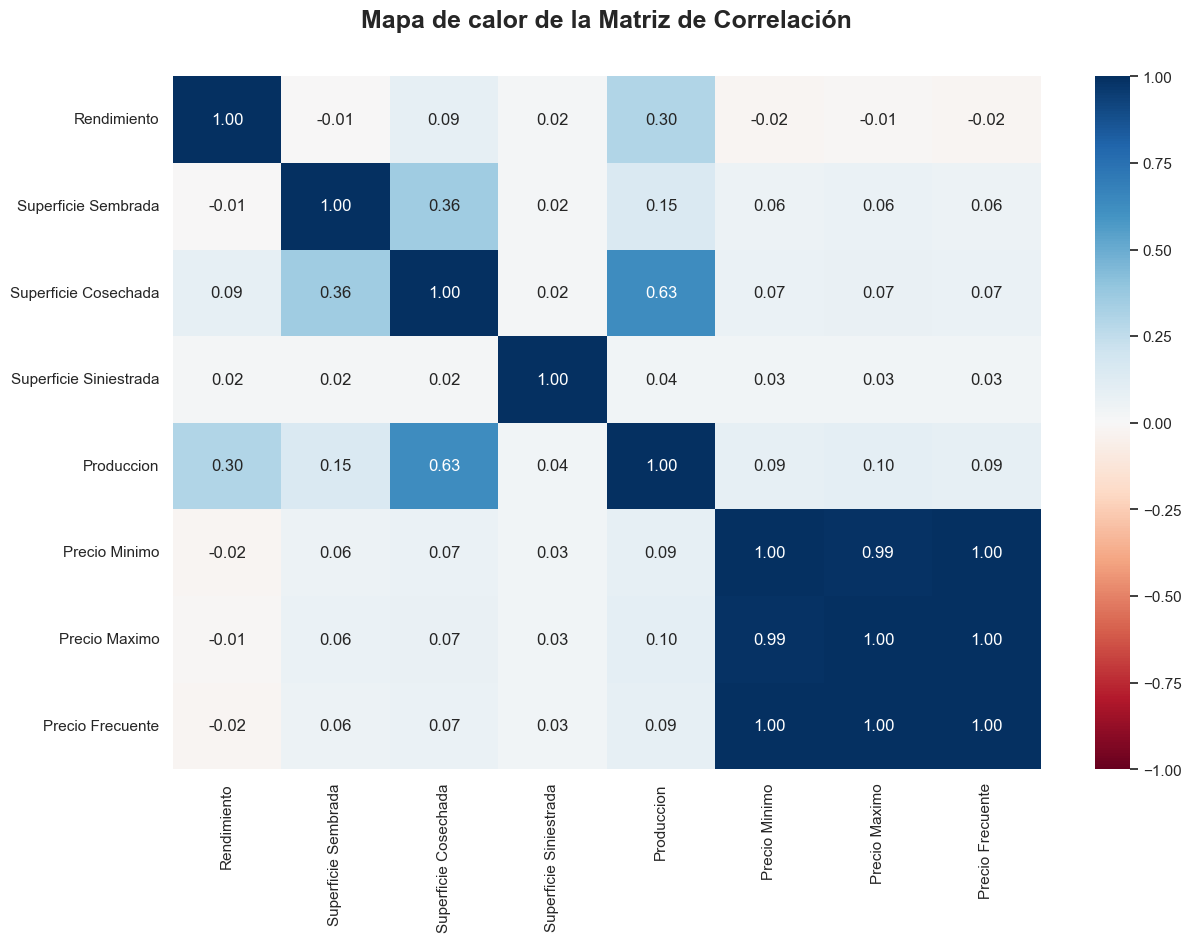

In [109]:
# Calcula la matriz de correlación
correlation_matrix = df_merge.drop(columns=['Año', 'Mes', 'Entidad', 'Cultivo', 'Superficie Sembrada Acumulada','Superficie Cosechada Acumulada', 'Superficie Siniestrada Acumulada', 'Produccion Acumulada']).corr()

# Fijar estilo
sns.set(style="white")

# Crea un mapa de calor de la matriz de correlación
plt.figure(figsize = (14,9))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap="RdBu", fmt=".2f", vmin=-1, vmax=1)
plt.title('Mapa de calor de la Matriz de Correlación', pad=40, ha='center', va='center', fontsize=18, fontweight='bold')
# Rotar los labels del eje x a 90 grados
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90)

#Mostrar gráfica
plt.show()
     

### PCA

In [135]:
# Seleccionar solo las columnas de interés
selected_columns = ['Precio Minimo','Precio Maximo', 'Precio Frecuente'] + ['Superficie Sembrada', 'Superficie Cosechada', 'Superficie Siniestrada', 'Produccion', 'Rendimiento']
df_selected = df_merge[selected_columns]

# Crear un objeto PCA y ajustarlo a los datos
n_components = 2
pca = PCA(n_components=n_components)

pca.fit(df_selected)

# Obtener las componentes principales y la varianza explicada
principal_components = pca.transform(df_selected)
explained_variance = pca.explained_variance_ratio_

# Crear un nuevo DataFrame con las componentes principales
columns = [f'PC{i+1}' for i in range(principal_components.shape[1])]
df_pca = pd.DataFrame(data=principal_components, columns=columns)

# Imprimir el DataFrame con las componentes principales
print(df_pca)

# Imprimir la varianza explicada por cada componente principal
print("\nVarianza explicada por cada componente principal:\n")
print(explained_variance)

               PC1          PC2
0     -9587.117374   136.556263
1     -9589.341110  -262.286168
2     -9594.460401  -146.214393
3     -9437.435695  5791.649074
4     14373.501835   396.882113
...            ...          ...
8418  -9595.269928  -284.178117
8419  -9596.297973  -287.951706
8420  -9599.130153  -298.362904
8421  -9599.269929  -298.903952
8422  -9596.714720  -289.486142

[8423 rows x 2 columns]

Varianza explicada por cada componente principal:

[0.96560923 0.02631997]


Unión de los datos

In [137]:
print(df_pca.shape)
print(df_merge.shape)

(8423, 2)
(8423, 16)


In [138]:
df_merge_pca = pd.merge(df_merge, df_pca, left_index=True, right_index=True)

#### Visualización de componentes principales

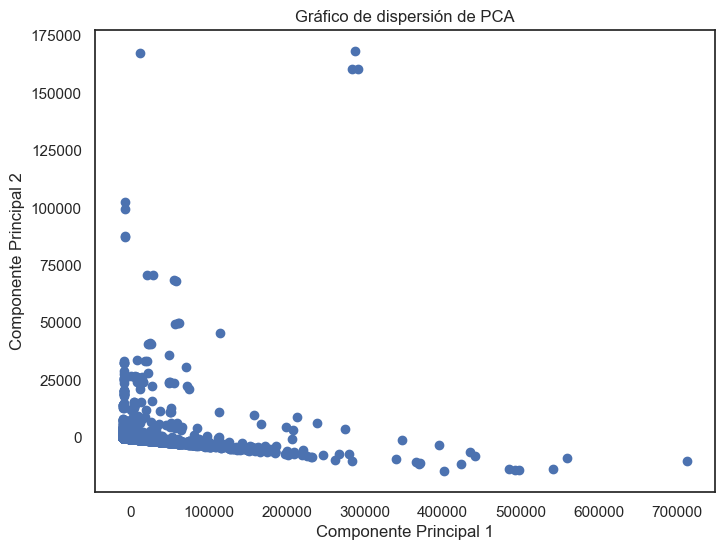

In [145]:
# Supongamos que tus componentes principales se llaman "PC1" y "PC2"
plt.figure(figsize=(8, 6))
plt.scatter(df_merge_pca['PC1'], df_merge_pca['PC2'])
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Gráfico de dispersión de PCA')

plt.show()

#### Resultados

| Componente Principal | Varianza     |
|----------------------|--------------|
| PC1                  | 0.96560923   |
| PC2                  | 0.02631997   |
